## Dataset preparation

In [1]:
import numpy as np
import math
import pandas as pd

import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

from scipy.integrate import solve_ivp

from torchmetrics import Accuracy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

from lion_pytorch import Lion

from tqdm import tqdm

from copy import deepcopy

import warnings
warnings.filterwarnings("ignore")

In [2]:
#df = pd.read_csv('dataset_arbi2d.csv')

#dataset1 = df.sample(n=10000, random_state=1)
#df_remaining = df.drop(dataset1.index)

#dataset2 = df_remaining.sample(n=10000, random_state=2)
#df_remaining = df_remaining.drop(dataset2.index)

#dataset3 = df_remaining.sample(n=10000, random_state=3)

#dataset1.to_csv("dataset_arbi2d_new_training_10000.csv", index=False)
#dataset2.to_csv("dataset_arbi2d_new_validation_10000.csv", index=False)
#dataset3.to_csv("dataset_arbi2d_new_testing_10000.csv", index=False)


In [3]:
#df_data = pd.read_csv('dataset_arbi2d_new_testing_10000.csv')

#df_data_1 = df_data[df_data['attracted'] == 1].sample(100)
#df_data_n1 = df_data[df_data['attracted'] == -1].sample(100)

#dataset_near = []
#for i in tqdm(range(len(df_data_1)), desc="Processing df_1"):
    #for j in range(len(df_data_n1)):
        #a = (df_data_1.iloc[i]['x0'], df_data_1.iloc[i]['y0'])
        #b = (df_data_n1.iloc[j]['x0'], df_data_n1.iloc[j]['y0'])
        #a, b = bisection(a, b)
        #dataset_near.append([a[0], a[1], 1])
        #dataset_near.append([b[0], b[1], -1])

#df_near = pd.DataFrame(dataset_near, columns=['x0', 'y0', 'attracted'])
#df_near.to_csv('dataset_arbi2d_new_testing_near_20000_0.1.csv', index=False)

In [4]:
#df = pd.read_csv('dataset_arbi2d_new_training_10000.csv')
#df_smaller = df.sample(n=1000)
#df_smaller.to_csv("dataset_arbi2d_new_training_1000.csv", index=False)

In [5]:
def system(t, X):
    x, y = X
    xp = -x-y-x*x
    yp = x-y-y*y
    return xp, yp

## Bisection method to generate near-boundary points
def bisection(a, b, delta=0.1): ## a has label +1 and b has label -1
    distance = np.linalg.norm(np.array([a[0]-b[0], a[1]-b[1]]))
    if distance < delta:
        return (a, b)
    else:
        c = ((a[0]+b[0])/2, (a[1]+b[1])/2)
        if simulation(c[0], c[1]):
            return bisection(c, b, delta)
        else:
            return bisection(a, c, delta)

def euclidean_distance(point1, point2):
    point1, point2 = np.array(point1), np.array(point2)
    return np.sqrt(np.sum((point1 - point2) ** 2))

spiral_sink = (0, 0)

# Check if the trajectory is attracted to the concerned spiral attractor
def is_attracted(x, y):
    return euclidean_distance((x, y), spiral_sink) < 1e-5

## Implement the simulation process and decide if the trajectory is attracted by the Lorenz attractor
def simulation(x0 ,y0):
    tmax, n = 1500, 100000
    soln = solve_ivp(system, (0, tmax), (x0, y0),dense_output=True)
    t = np.linspace(0, tmax, n)
    x, y= soln.sol(t)
    return is_attracted(x[n-1], y[n-1])


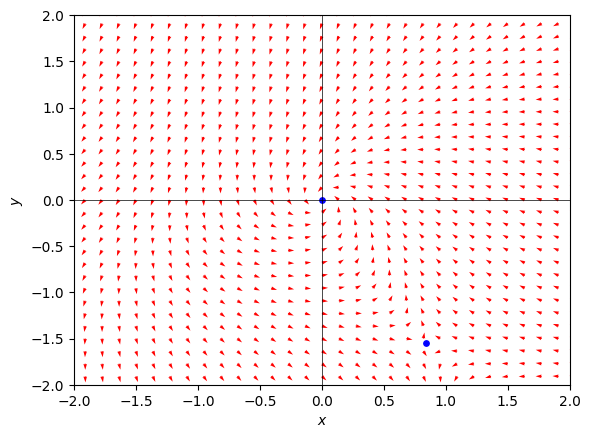

In [6]:
# Define the system of equations
Y, X = np.mgrid[-3:3:45j, -3:3:45j] 
U, V = system(0, (X, Y))

# Normalize arrows
N = np.sqrt(U**2 + V**2)
U = U / N
V = V / N

plt.quiver(X, Y, U, V, color='r')

# Highlight critical points
plt.scatter([0, 0.83928], [0, -1.54368], color='blue', s=15) 

# Add axes
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)

plt.xlim([-2, 2])  # x-axis limits include negative values
plt.ylim([-2, 2])  # y-axis limits include negative values
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.show()

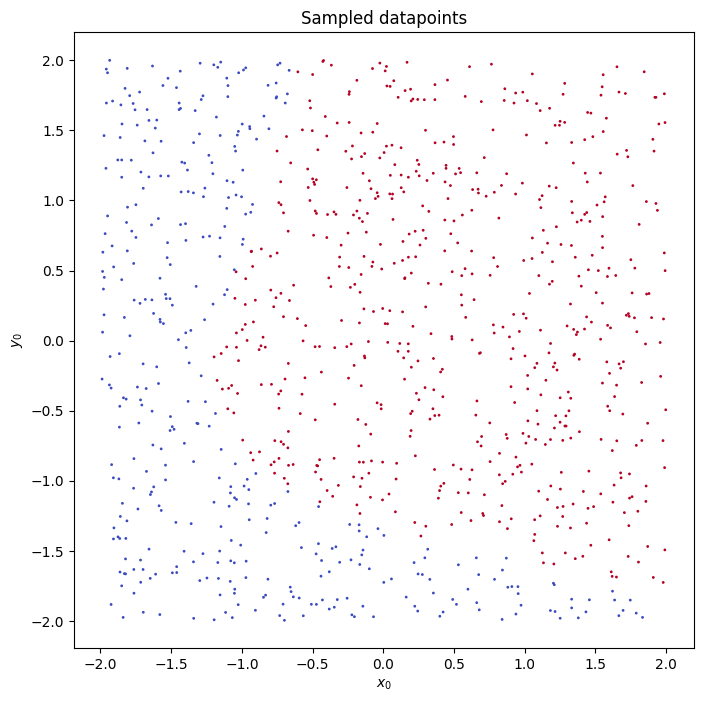

In [7]:
## Plot the sampled datapoints
df = pd.read_csv('dataset_arbi2d_new_training_1000.csv')
plt.figure(figsize=(8, 8))
plt.scatter(df['x0'], df['y0'], c=df['attracted'], cmap='coolwarm', s=1)
plt.xlabel('$x_0$')
plt.ylabel('$y_0$')
plt.title('Sampled datapoints')
plt.show()

## Baseline training

In [8]:
class SystemDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.data.iloc[idx, 0:2].values).float()
        y = torch.tensor(self.data.iloc[idx, 2]).float()
        return x, y
    


In [9]:
## Define the neural network. The complexity of the network is a hyperparameter.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2,32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 1)

        #self.bn1 = nn.BatchNorm1d(32)
        #self.bn2 = nn.BatchNorm1d(32)
        #self.bn3 = nn.BatchNorm1d(32)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        #x = self.bn1(x)
        x = torch.relu(self.fc2(x))
        #x = self.bn2(x)
        x = torch.relu(self.fc3(x))
        #x = self.bn3(x)
        x = self.fc4(x)
        return x
    

In [10]:
def train_model_bce(net, dataset_train, dataset_validation1, dataset_validation2, batchsize, epochs, lr):
    criterion = nn.BCEWithLogitsLoss()
    #optimizer = optim.Adam(net.parameters(), lr=lr)
    optimizer = Lion(net.parameters(), lr=lr, weight_decay=0.01)
    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
    dataloader_validation1 = DataLoader(dataset_validation1, batch_size=batchsize, shuffle=False)
    dataloader_validation2 = DataLoader(dataset_validation2, batch_size=batchsize, shuffle=False)
    
    training_accuracy_over_epochs = []
    validation1_accuracy_over_epochs = []
    validation2_accuracy_over_epochs = []
    training_loss_over_epochs = []
    validation1_loss_over_epochs = []
    validation2_loss_over_epochs = []
    
    # Set up the overall progress bar
    overall_progress = tqdm(total=epochs, desc='Overall Training Progress')
    
    for epoch in range(epochs):
        net.train()
        correct_train = 0
        total_train = 0
        avg_loss_train = 0
        for features, labels in dataloader_train:
            labels = ((labels + 1) / 2).float()
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = net(features).view(-1)
            predicted = (outputs > 0).float()
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            loss = criterion(outputs, labels)
            avg_loss_train += loss.item()
            loss.backward()
            optimizer.step()
                    
        training_accuracy = correct_train / total_train
        training_loss = avg_loss_train / len(dataloader_train)
        training_accuracy_over_epochs.append(training_accuracy)
        training_loss_over_epochs.append(training_loss)

        
        net.eval()
        correct_validation1 = 0
        total_validation1 = 0
        avg_loss_validation1 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation1:
                labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = (outputs > 0).float()
                correct_validation1 += (predicted == labels).sum().item()
                total_validation1 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation1 += loss.item()
        
        validation1_accuracy = correct_validation1 / total_validation1
        validation1_accuracy_over_epochs.append(validation1_accuracy)
        validation1_loss = avg_loss_validation1 / len(dataloader_validation1)
        validation1_loss_over_epochs.append(validation1_loss)

        correct_validation2 = 0
        total_validation2 = 0
        avg_loss_validation2 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation2:
                labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = (outputs > 0).float()
                correct_validation2 += (predicted == labels).sum().item()
                total_validation2 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation2 += loss.item()
        
        validation2_accuracy = correct_validation2 / total_validation2
        validation2_accuracy_over_epochs.append(validation2_accuracy)
        validation2_loss = avg_loss_validation2 / len(dataloader_validation2)
        validation2_loss_over_epochs.append(validation2_loss)
        
        # Update the overall progress bar after each epoch
        overall_progress.update(1)
        overall_progress.set_postfix({'Training Accuracy': training_accuracy, 'Validation1 Accuracy': validation1_accuracy, 'Validation2 Accuracy': validation2_accuracy})
    
    overall_progress.close()
    
    # Plot training and validation accuracy over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(training_accuracy_over_epochs, label='Training Accuracy')
    plt.plot(validation1_accuracy_over_epochs, label='Validation1 Accuracy')
    plt.plot(validation2_accuracy_over_epochs, label='Validation2 Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()
    plt.show()

    # Plot training and validation loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(training_loss_over_epochs, label='Training Loss')
    plt.plot(validation1_loss_over_epochs, label='Validation1 Loss')
    plt.plot(validation2_loss_over_epochs, label='Validation2 Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()
    
    test_model(net, dataset_train)
    test_model(net, dataset_validation1)
    test_model(net, dataset_validation2)

    

def test_model(net, dataset_test):
    net.eval()
    dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)
    features_list = []
    labels_list = []
    probability_list = []
    predictions_list = []
    acc = Accuracy(task = 'binary')

    with torch.no_grad():
        for features, labels in dataloader_test:
            labels = ((labels + 1) / 2).float()
            probability = net(features)
            outputs = (probability > 0).float()
            outputs = outputs.squeeze()

            acc.update(outputs, labels)

            # Move features, labels, and outputs to CPU and convert them to numpy arrays
            features_list.append(features.numpy())
            labels_list.append(labels.numpy())
            probability_list.append(probability.numpy())
            predictions_list.append(outputs.numpy())
    accuracy = acc.compute()
    print(f'Accuracy: {accuracy}')

    # Concatenate all batches
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    probability = np.concatenate(probability_list, axis=0)
    predictions = np.concatenate(predictions_list, axis=0)

    # Create a 2D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Plot the features colored by the predictions
    scatter = ax.scatter(features[:, 0], features[:, 1], c=probability, cmap='coolwarm', vmin=-np.max(np.abs(probability)), vmax=np.max(np.abs(probability)))

    # Add a color bar
    plt.colorbar(scatter)

    plt.show()

    plt.hist(probability, bins=20)
    plt.show()
    return accuracy

In [11]:
'''
dataset_train: uniformly sampled 1,000 points
dataset_validation_uniform: uniformly sampled 1,000 points
dataset_test_uniform: uniformly sampled 1,000 points
dataset_validation_near: 1,000 points near the boundary
dataset_test_near: 1,000 points near the boundary
Each dataset above are mutually independent
'''
dataset_train = SystemDataset('dataset_arbi2d_new_training_1000.csv')

dataset_validation_uniform = SystemDataset('dataset_arbi2d_new_validation_10000.csv')
dataset_validation_uniform.data = dataset_validation_uniform.data.sample(n=1000)

dataset_test_uniform = SystemDataset('dataset_arbi2d_new_testing_10000.csv')
dataset_test_uniform.data = dataset_test_uniform.data.sample(n=1000)

df_near_eval = pd.read_csv('dataset_arbi2d_new_testing_near_20000.csv')
df_validation_near = df_near_eval.sample(n=1000)
remaining_df = df_near_eval.drop(df_validation_near.index)
df_test_near = remaining_df.sample(n=1000)
remaining_df = df_near_eval.drop(df_test_near.index)
df_dynamical = remaining_df.sample(n=1000)

dataset_validation_near = SystemDataset('dataset_arbi2d_new_testing_near_20000.csv')
dataset_validation_near.data = df_validation_near

dataset_test_near = SystemDataset('dataset_arbi2d_new_testing_near_20000.csv')
dataset_test_near.data = df_test_near


Overall Training Progress: 100%|██████████| 1000/1000 [02:04<00:00,  8.05it/s, Training Accuracy=0.999, Validation1 Accuracy=0.994, Validation2 Accuracy=0.594]


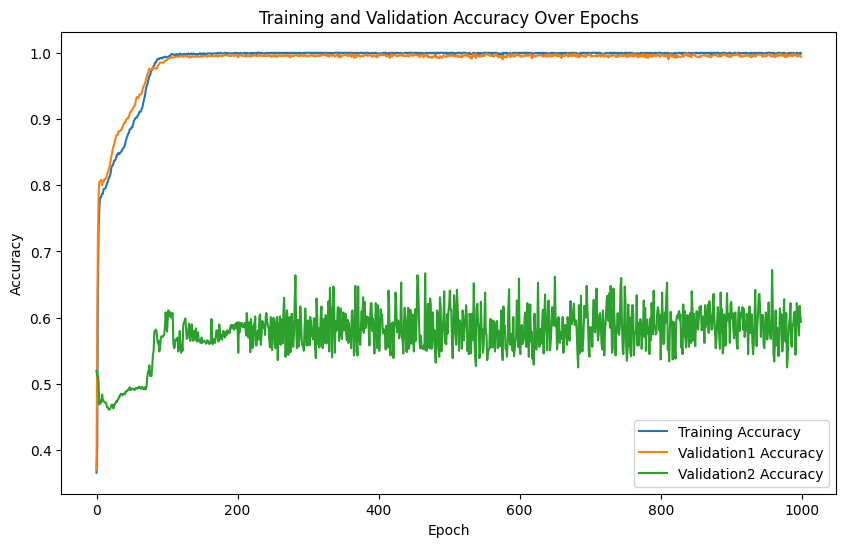

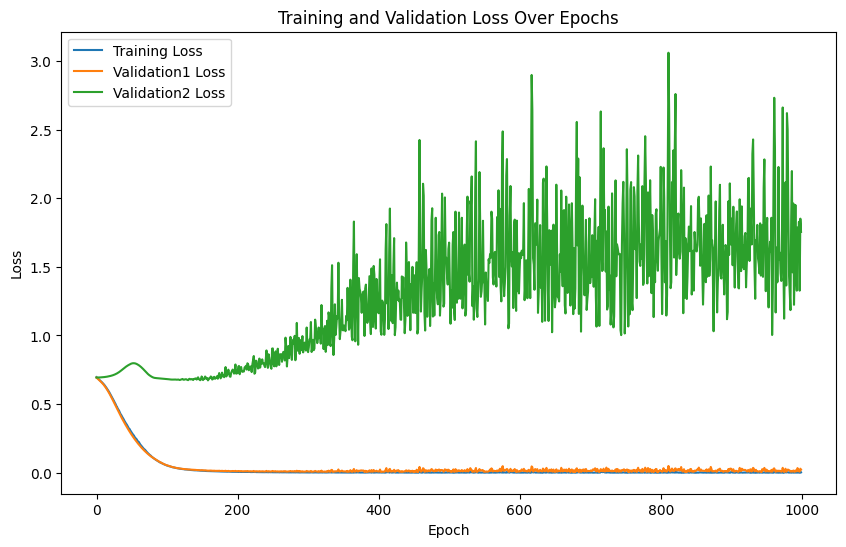

Accuracy: 0.9990000128746033


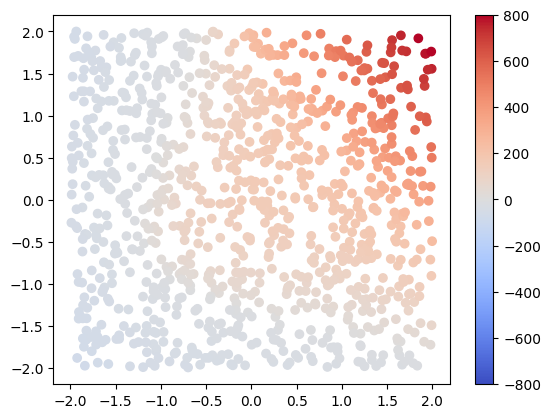

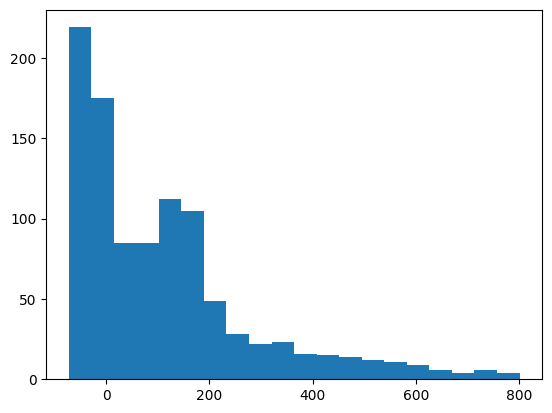

Accuracy: 0.9940000176429749


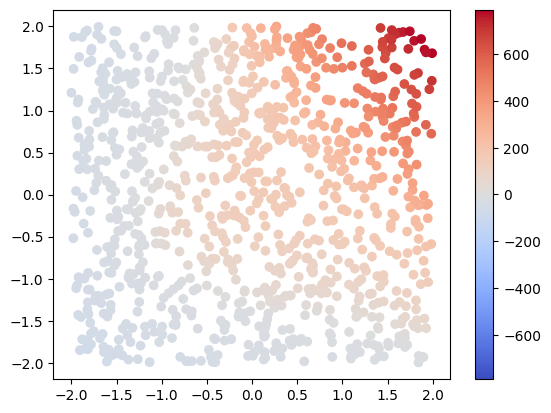

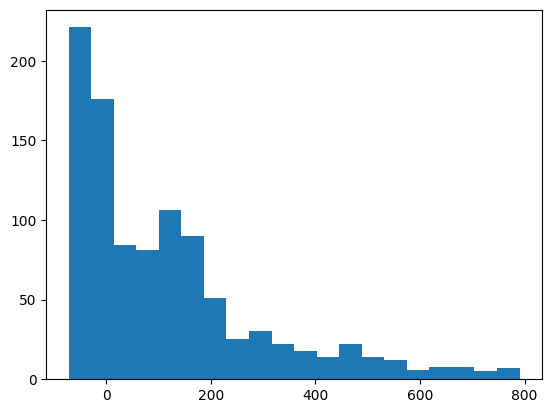

Accuracy: 0.593999981880188


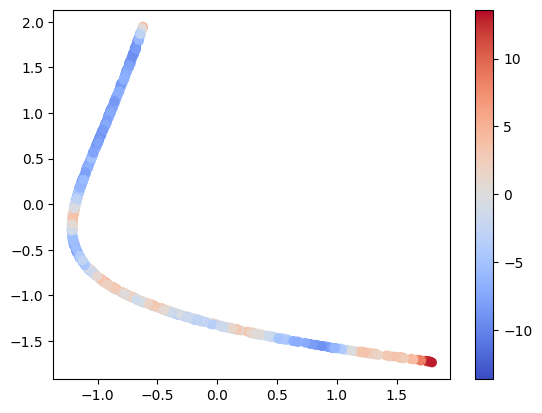

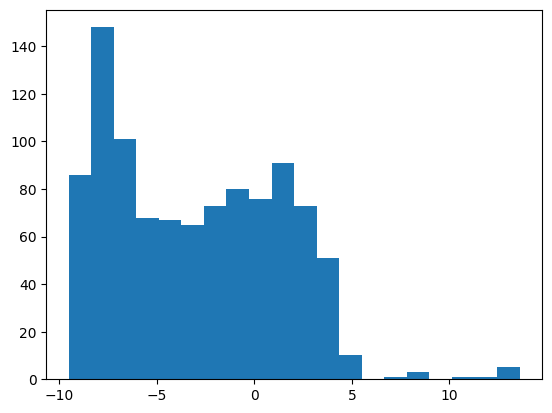

In [12]:
net_1 = Net()
train_model_bce(net_1, dataset_train, dataset_validation_uniform, dataset_validation_near, batchsize=64, epochs=1000, lr=0.0001)

Accuracy: 0.9950000047683716


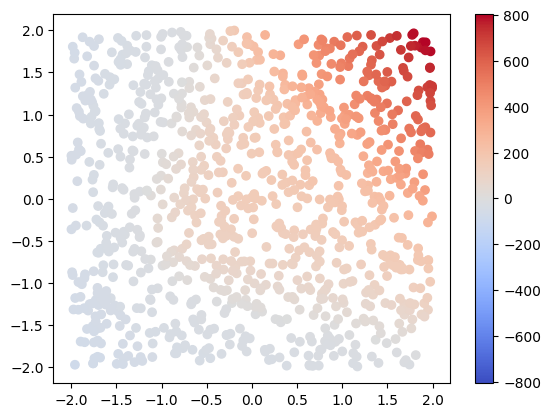

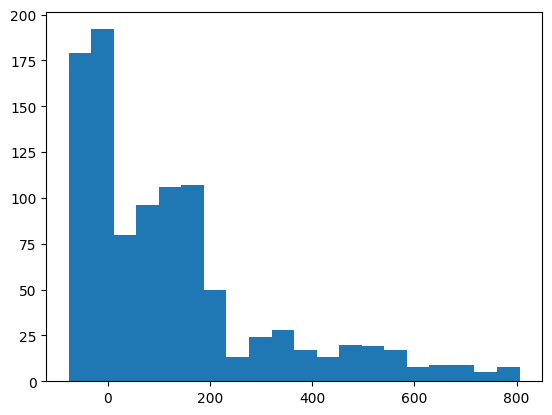

tensor(0.9950)

In [13]:
test_model(net_1, dataset_test_uniform)

Accuracy: 0.5759999752044678


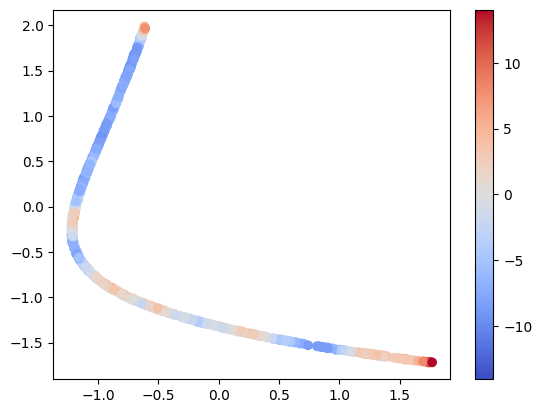

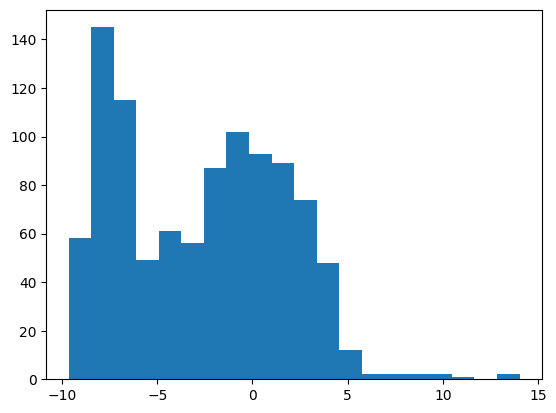

tensor(0.5760)

In [14]:
test_model(net_1, dataset_test_near)

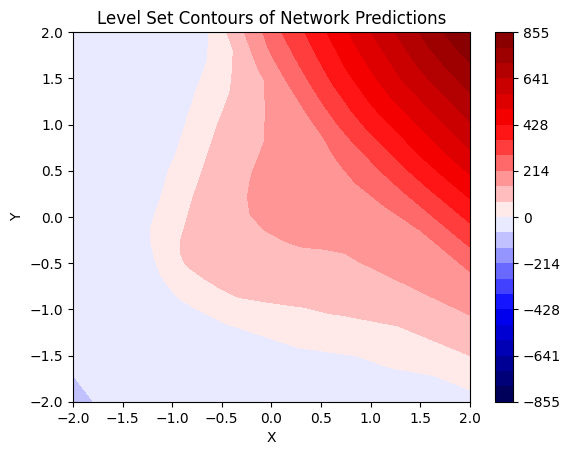

In [15]:
def plot_contour(net):
    x_min, x_max = -2, 2
    y_min, y_max = -2, 2
    resolution = 2000
    x_range = np.linspace(x_min, x_max, resolution)
    y_range = np.linspace(y_min, y_max, resolution)
    xx, yy = np.meshgrid(x_range, y_range)
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points_tensor = torch.tensor(grid_points, dtype=torch.float)
    
    with torch.no_grad():
        predictions = net(grid_points_tensor).numpy()
    
    predictions_reshaped = predictions.reshape(xx.shape)
    
    # Ensure the color scale is centered around 0
    vmin = -max(abs(predictions_reshaped.min()), abs(predictions_reshaped.max()))
    vmax = max(abs(predictions_reshaped.min()), abs(predictions_reshaped.max()))
    
    plt.contourf(xx, yy, predictions_reshaped, levels=np.linspace(vmin, vmax, 25), cmap='seismic', vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title("Level Set Contours of Network Predictions")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

plot_contour(net_1)


## Data augmentation

In [16]:
df_data = dataset_train.data

df_data_1 = df_data[df_data['attracted'] == 1].sample(15)
df_data_n1 = df_data[df_data['attracted'] == -1].sample(15)

dataset_near = []
for i in tqdm(range(len(df_data_1)), desc="Processing df_1"):
    for j in range(len(df_data_n1)):
        a = (df_data_1.iloc[i]['x0'], df_data_1.iloc[i]['y0'])
        b = (df_data_n1.iloc[j]['x0'], df_data_n1.iloc[j]['y0'])
        a, b = bisection(a, b)
        dataset_near.append([a[0], a[1], 1])
        dataset_near.append([b[0], b[1], -1])

df_near = pd.DataFrame(dataset_near, columns=['x0', 'y0', 'attracted'])

dataset_train.data = pd.concat([dataset_train.data, df_near], ignore_index=True)

Processing df_1: 100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


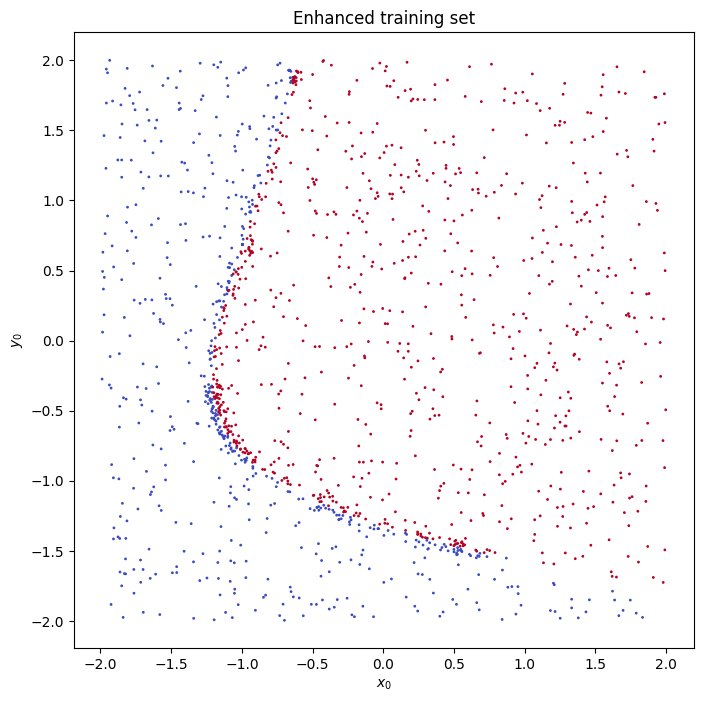

In [17]:
plt.figure(figsize=(8, 8))
plt.scatter(dataset_train.data['x0'], dataset_train.data['y0'], c=dataset_train.data['attracted'], cmap='coolwarm', s=1)
plt.xlabel('$x_0$')
plt.ylabel('$y_0$')
plt.title('Enhanced training set')
plt.show()

In [18]:
def train_model_bce_augment(net, dataset_train, dataset_validation1, dataset_validation2, batchsize, epochs, lr):
    criterion = nn.BCEWithLogitsLoss()
    #optimizer = optim.Adam(net.parameters(), lr=lr)
    optimizer = Lion(net.parameters(), lr=lr, weight_decay=0.01)
    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
    dataloader_validation1 = DataLoader(dataset_validation1, batch_size=batchsize, shuffle=False)
    dataloader_validation2 = DataLoader(dataset_validation2, batch_size=batchsize, shuffle=False)
    
    training_accuracy_over_epochs = []
    validation1_accuracy_over_epochs = []
    validation2_accuracy_over_epochs = []
    training_loss_over_epochs = []
    validation1_loss_over_epochs = []
    validation2_loss_over_epochs = []
    
    # Set up the overall progress bar
    overall_progress = tqdm(total=epochs, desc='Overall Training Progress')
    
    for epoch in range(epochs):
        net.train()
        correct_train = 0
        total_train = 0
        avg_loss_train = 0
        for features, labels in dataloader_train:
            labels = ((labels + 1) / 2).float()
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = net(features).view(-1)
            predicted = (outputs > 0).float()
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            loss = criterion(outputs, labels)
            avg_loss_train += loss.item()
            loss.backward()
            optimizer.step()
                    
        training_accuracy = correct_train / total_train
        training_loss = avg_loss_train / len(dataloader_train)
        training_accuracy_over_epochs.append(training_accuracy)
        training_loss_over_epochs.append(training_loss)

        
        net.eval()
        correct_validation1 = 0
        total_validation1 = 0
        avg_loss_validation1 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation1:
                labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = (outputs > 0).float()
                correct_validation1 += (predicted == labels).sum().item()
                total_validation1 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation1 += loss.item()
        
        validation1_accuracy = correct_validation1 / total_validation1
        validation1_accuracy_over_epochs.append(validation1_accuracy)
        validation1_loss = avg_loss_validation1 / len(dataloader_validation1)
        validation1_loss_over_epochs.append(validation1_loss)

        correct_validation2 = 0
        total_validation2 = 0
        avg_loss_validation2 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation2:
                labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = (outputs > 0).float()
                correct_validation2 += (predicted == labels).sum().item()
                total_validation2 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation2 += loss.item()
        
        validation2_accuracy = correct_validation2 / total_validation2
        validation2_accuracy_over_epochs.append(validation2_accuracy)
        validation2_loss = avg_loss_validation2 / len(dataloader_validation2)
        validation2_loss_over_epochs.append(validation2_loss)
        
        # Update the overall progress bar after each epoch
        overall_progress.update(1)
        overall_progress.set_postfix({'Training Accuracy': training_accuracy, 'Validation1 Accuracy': validation1_accuracy, 'Validation2 Accuracy': validation2_accuracy})
    
    overall_progress.close()
    
    # Plot training and validation accuracy over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(training_accuracy_over_epochs, label='Training Accuracy')
    plt.plot(validation1_accuracy_over_epochs, label='Validation1 Accuracy')
    plt.plot(validation2_accuracy_over_epochs, label='Validation2 Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()
    plt.show()

    # Plot training and validation loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(training_loss_over_epochs, label='Training Loss')
    plt.plot(validation1_loss_over_epochs, label='Validation1 Loss')
    plt.plot(validation2_loss_over_epochs, label='Validation2 Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()
    
    test_model(net, dataset_train)
    test_model(net, dataset_validation1)
    test_model(net, dataset_validation2)

Overall Training Progress: 100%|██████████| 1000/1000 [02:30<00:00,  6.63it/s, Training Accuracy=0.994, Validation1 Accuracy=0.999, Validation2 Accuracy=0.662]


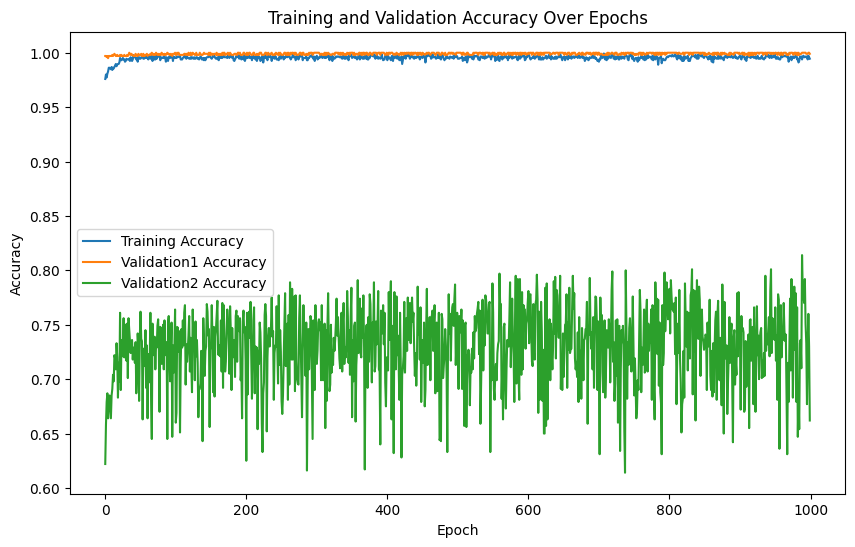

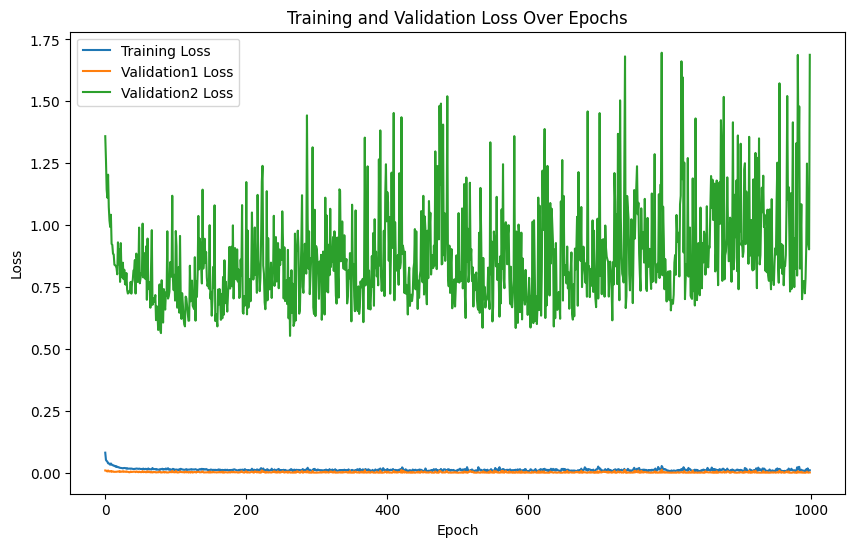

Accuracy: 0.9917241334915161


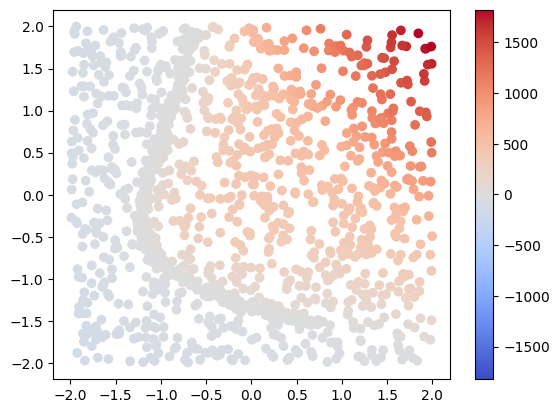

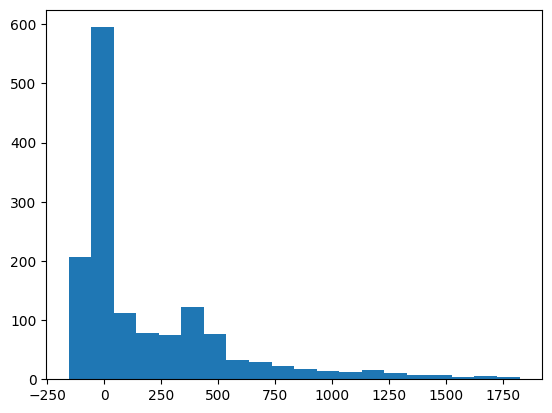

Accuracy: 0.9990000128746033


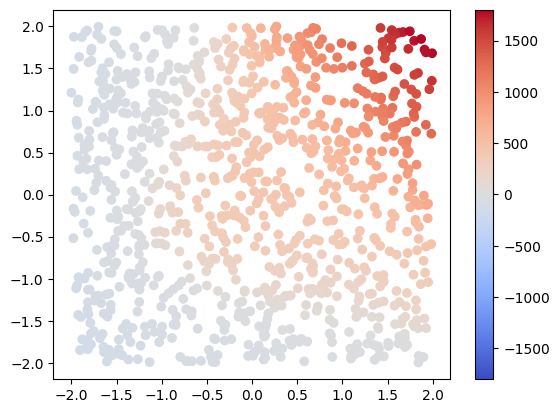

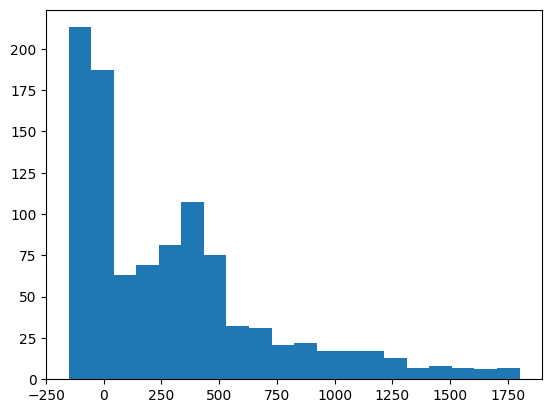

Accuracy: 0.6620000004768372


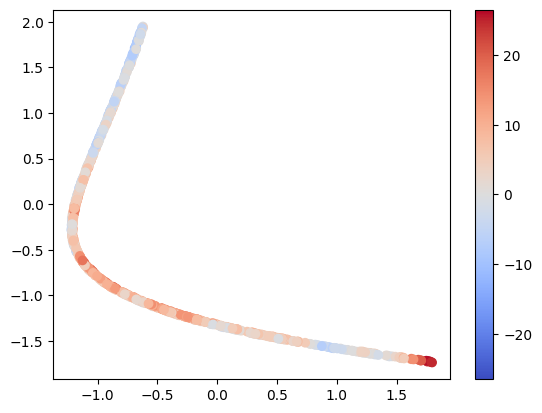

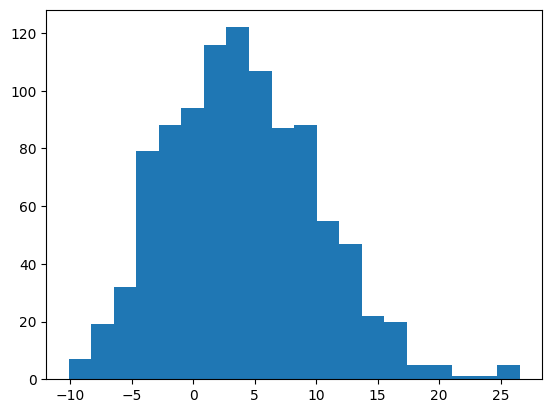

In [19]:
net_2 = deepcopy(net_1)
train_model_bce(net_2, dataset_train, dataset_validation_uniform, dataset_validation_near, batchsize=64, epochs=1000, lr=0.0001)

Accuracy: 1.0


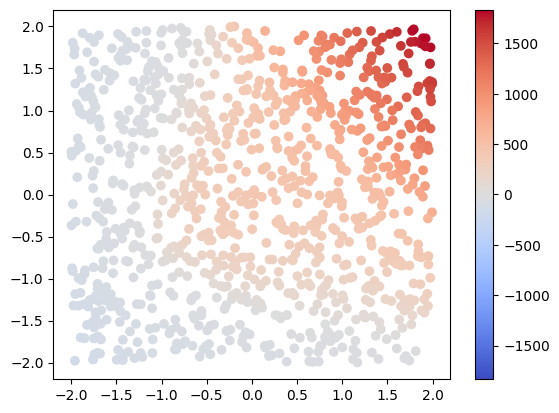

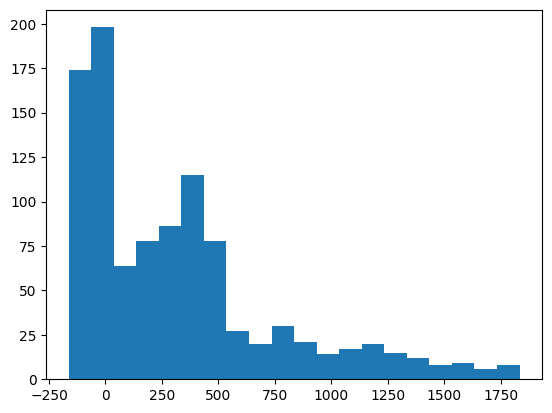

tensor(1.)

In [20]:
test_model(net_2, dataset_test_uniform)

Accuracy: 0.6309999823570251


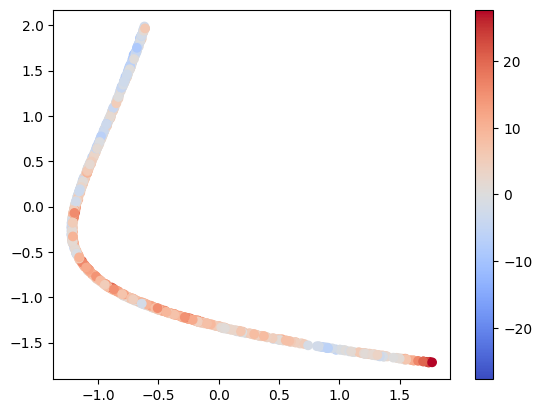

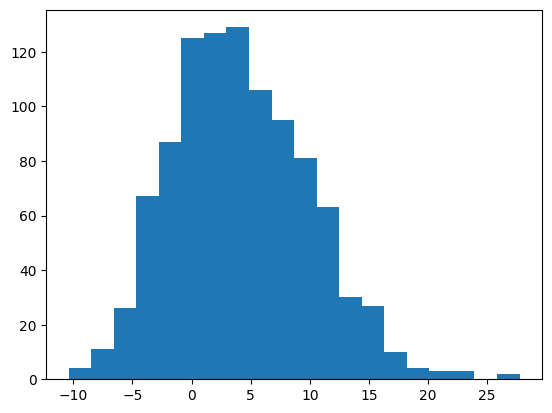

tensor(0.6310)

In [21]:
test_model(net_2, dataset_test_near)

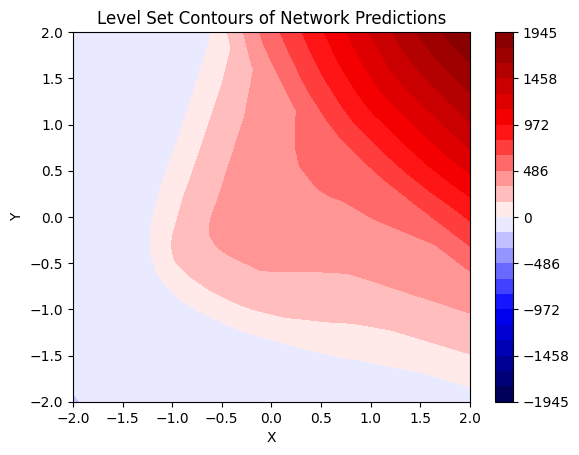

In [22]:
plot_contour(net_2)

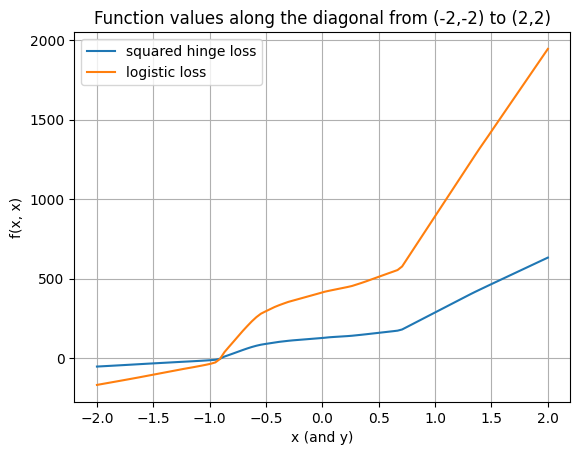

In [45]:
# Define the function f that takes a 2D tensor as input (e.g., your model)
def f(coord):
    # Assuming net_1 is your model
    return net_hinge_square(coord)

def g(coord):
    return net_2(coord)

# Generate points along the diagonal from (-2,-2) to (2,2)
x_vals = np.linspace(-2, 2, 100)
y_vals = x_vals  # Since we're along the diagonal, y = x

# Evaluate the function along the diagonal
z_vals = []
w_vals = []
for x, y in zip(x_vals, y_vals):
    coord = torch.tensor([x, y], dtype=torch.float32)  # Ensure the tensor is float32
    z_vals.append(f(coord).item())
    w_vals.append(g(coord).item())



# Convert z_vals to a numpy array for plotting
z_vals = np.array(z_vals)
w_vals = np.array(w_vals)

# Plotting
plt.plot(x_vals, z_vals, label='squared hinge loss')
plt.plot(x_vals, w_vals, label="logistic loss")

plt.xlabel('x (and y)')
plt.ylabel('f(x, x)')
plt.title('Function values along the diagonal from (-2,-2) to (2,2)')
plt.legend()
plt.grid(True)
plt.show()


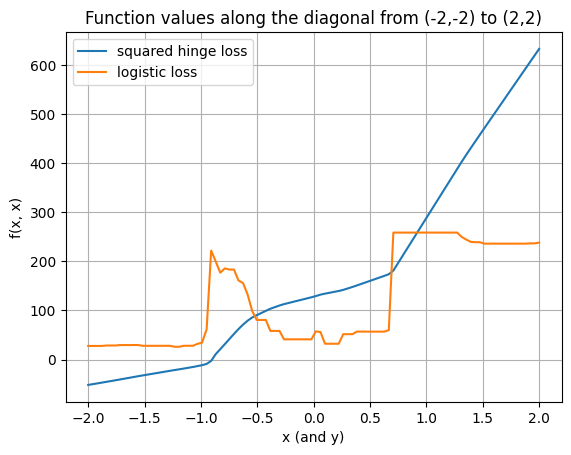

In [46]:
# Define the function f that takes a 2D tensor as input (e.g., your model)
def f(coord):
    # Assuming net_1 is your model
    return net_hinge_square(coord)

def g(coord):
    value = net_hinge_square(coord)
    value.backward()
    gradient = coord.grad
    return np.linalg.norm(gradient)

# Generate points along the diagonal from (-2,-2) to (2,2)
x_vals = np.linspace(-2, 2, 100)
y_vals = x_vals  # Since we're along the diagonal, y = x

# Evaluate the function along the diagonal
z_vals = []
w_vals = []
for x, y in zip(x_vals, y_vals):
    coord = torch.tensor([x, y], dtype=torch.float32, requires_grad=True)  # Ensure the tensor is float32
    z_vals.append(f(coord).item())
    w_vals.append(g(coord).item())



# Convert z_vals to a numpy array for plotting
z_vals = np.array(z_vals)
w_vals = np.array(w_vals)

# Plotting
plt.plot(x_vals, z_vals, label='squared hinge loss')
plt.plot(x_vals, w_vals, label="logistic loss")

plt.xlabel('x (and y)')
plt.ylabel('f(x, x)')
plt.title('Function values along the diagonal from (-2,-2) to (2,2)')
plt.legend()
plt.grid(True)
plt.show()


The enhancement of training set is desirable in the sense that it reduces confidence of the model. Now the model tends to assign probability close to 0.5 if a point is close to boundary.

## Adaptive of weightage

In [ ]:
class WeightedSystemDataset(Dataset):
    def __init__(self, csv_file, weight=1.0):
        self.data = pd.read_csv(csv_file)
        # Initialize weight as a tensor of ones with the same length as the dataset
        self.weight = torch.full((len(self.data),), weight, dtype=torch.float32)
        # Normalize the weights
        self.weight /= self.weight.sum()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.data.iloc[idx, 0:2].values).float()
        y = torch.tensor(self.data.iloc[idx, 2]).float()
        weight = self.weight[idx]  # Get the weight for the current data point
        return x, y, weight
    
    def weight_reinitialization(self):
        # Reinitialize the weights as a tensor of ones with the same length as the dataset
        self.weight = torch.full((len(self.data),), 1.0, dtype=torch.float32)
        # Normalize the weights
        self.weight /= self.weight.sum()

In [ ]:
def update_weights(net, dataset_train, sigma):
    net.eval()
    
    dataloader = DataLoader(dataset_train, batch_size=len(dataset_train), shuffle=False)
    
    for features, *_ in dataloader:
        with torch.no_grad():
            predicted_probs = net(features).view(-1)
    
    adjusted_probs = predicted_probs
    
    # Compute the new weights using the Gaussian PDF formula. The variance is sigma^2, and mean (mu) is 0
    new_weights = (1 / (np.sqrt(2 * np.pi * sigma**2))) * torch.exp(-((adjusted_probs)**2) / (2 * sigma**2))
    new_weights /= new_weights.sum()
    
    return new_weights

In [ ]:
def train_model_bce_with_weight_update(net, dataset_train, dataset_validation1, dataset_validation2, batchsize, epochs, lr):
    criterion = nn.BCEWithLogitsLoss(reduction='none')
    optimizer = optim.Adam(net.parameters(), lr=lr)
    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
    dataloader_validation1 = DataLoader(dataset_validation1, batch_size=batchsize, shuffle=False)
    dataloader_validation2 = DataLoader(dataset_validation2, batch_size=batchsize, shuffle=False)
    
    training_accuracy_over_epochs = []
    validation1_accuracy_over_epochs = []
    validation2_accuracy_over_epochs = []
    training_loss_over_epochs = []
    validation1_loss_over_epochs = []
    validation2_loss_over_epochs = []
    
    overall_progress = tqdm(total=epochs, desc='Overall Training Progress')
    
    for epoch in range(epochs):
        net.train()
        correct_predictions_train = 0
        total_predictions_train = 0
        avg_loss_train = 0
        for features, labels, weights in dataloader_train:
            labels = ((labels + 1) / 2).float()
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = net(features).view(-1)
            loss = criterion(outputs, labels)
            weighted_loss = (loss * weights).sum()
            weighted_loss.backward()
            optimizer.step()
            correct_predictions_train += ((outputs > 0) == labels).float().sum().item()
            total_predictions_train += labels.size(0)
            avg_loss_train += weighted_loss.item()

                    
        avg_training_accuracy = correct_predictions_train / total_predictions_train
        training_accuracy_over_epochs.append(avg_training_accuracy)
        avg_training_loss = avg_loss_train / len(dataloader_train)
        training_loss_over_epochs.append(avg_training_loss)
        
        net.eval()
        correct_predictions_validation1 = 0
        total_predictions_validation1 = 0
        avg_loss_validation1 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation1:
                labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                correct_predictions_validation1 += ((outputs > 0) == labels).float().sum().item()
                total_predictions_validation1 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation1 += loss.mean().item()
        
        avg_validation1_accuracy = correct_predictions_validation1 / total_predictions_validation1
        validation1_accuracy_over_epochs.append(avg_validation1_accuracy)
        avg_validation1_loss = avg_loss_validation1 / len(dataloader_validation1)
        validation1_loss_over_epochs.append(avg_validation1_loss)

        correct_predictions_validation2 = 0
        total_predictions_validation2 = 0
        avg_loss_validation2 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation2:
                labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                correct_predictions_validation2 += ((outputs > 0) == labels).float().sum().item()
                total_predictions_validation2 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation2 += loss.mean().item()
        
        avg_validation2_accuracy = correct_predictions_validation2 / total_predictions_validation2
        validation2_accuracy_over_epochs.append(avg_validation2_accuracy)
        avg_validation2_loss = avg_loss_validation2 / len(dataloader_validation2)
        validation2_loss_over_epochs.append(avg_validation2_loss)

        if (epoch + 1 ) % 250 == 0:
            time = (epoch + 1) // 250
            new_weights = update_weights(net, dataset_train, sigma=(1-0.1*time))
            dataset_train.weight = new_weights
            dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
        
        overall_progress.update(1)
        overall_progress.set_postfix({'Training Accuracy': avg_training_accuracy, 'Validation1 Accuracy': avg_validation1_accuracy, 'Validation2 Accuracy': avg_validation2_accuracy})
        
    
    overall_progress.close()
    
    plt.figure(figsize=(10, 6))
    plt.plot(training_accuracy_over_epochs, label='Training Accuracy')
    plt.plot(validation1_accuracy_over_epochs, label='Validation1 Accuracy')
    plt.plot(validation2_accuracy_over_epochs, label='Validation2 Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(training_loss_over_epochs, label='Training Loss')
    plt.plot(validation1_loss_over_epochs, label='Validation1 Loss')
    plt.plot(validation2_loss_over_epochs, label='Validation2 Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()
    
    test_model(net, dataset_validation1)
    test_model(net, dataset_validation2)

In [ ]:
dataset_train_weighted = WeightedSystemDataset('dataset_arbi2d_new_training_1000.csv')
dataset_train_weighted.data = dataset_train.data
dataset_train_weighted.weight_reinitialization()

In [ ]:
net_3_1 = deepcopy(net_1)
train_model_bce_with_weight_update(net_3_1, dataset_train_weighted, dataset_validation_uniform, dataset_validation_near, batchsize=32, epochs=1000, lr=0.0001)

In [ ]:
check = dataset_train_weighted.weight

In [ ]:
histogram = plt.hist(check, bins=20)

In [ ]:
plt.scatter(dataset_train_weighted.data['x0'], dataset_train_weighted.data['y0'], c=check, cmap='coolwarm', s=1)
plt.colorbar()
plt.show()

In [ ]:
test_model(net_3_1, dataset_test_uniform)

In [ ]:
test_model(net_3_1, dataset_test_near)

In [ ]:
plot_contour(net_3_1)

In [ ]:
#net_3_2 = deepcopy(net_2)
#train_model_bce_with_weight_update(net_3_2, dataset_train_weighted, dataset_validation_uniform, dataset_validation_near, batchsize=32, epochs=10000, lr=0.0001)

In [ ]:
#test_model(net_3_2, dataset_test_uniform)

In [ ]:
#test_model(net_3_2, dataset_test_near)

## Hinge loss and quadratic hinge loss

In [23]:
class HingeLoss(nn.Module):
    def __init__(self):
        super(HingeLoss, self).__init__()
    
    def forward(self, y_pred, y_true):
        loss = nn.functional.relu(1-y_true * y_pred)
        mean_loss = torch.mean(loss)
        return mean_loss
    
class QuadraticHingeLoss(nn.Module):
    def __init__(self):
        super(QuadraticHingeLoss, self).__init__()

    def forward(self, y_pred, y_true):
        loss = nn.functional.relu(1-y_true * y_pred) ** 2
        mean_loss = torch.mean(loss)
        return mean_loss

In [24]:
def train_model_hinge(net, dataset_train, dataset_validation1, dataset_validation2, batchsize, epochs, lr):
    criterion = HingeLoss()
    #optimizer = optim.Adam(net.parameters(), lr=lr)
    optimizer = Lion(net.parameters(), lr=lr, weight_decay=0.01)
    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
    dataloader_validation1 = DataLoader(dataset_validation1, batch_size=batchsize, shuffle=False)
    dataloader_validation2 = DataLoader(dataset_validation2, batch_size=batchsize, shuffle=False)
    
    training_accuracy_over_epochs = []
    validation1_accuracy_over_epochs = []
    validation2_accuracy_over_epochs = []
    training_loss_over_epochs = []
    validation1_loss_over_epochs = []
    validation2_loss_over_epochs = []
    
    # Set up the overall progress bar
    overall_progress = tqdm(total=epochs, desc='Overall Training Progress')
    
    for epoch in range(epochs):
        net.train()
        correct_train = 0
        total_train = 0
        avg_loss_train = 0
        for features, labels in dataloader_train:
            #labels = ((labels + 1) / 2).float()
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = net(features).view(-1)
            predicted = ((outputs > 0).float() * 2) - 1
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            loss = criterion(outputs, labels)
            avg_loss_train += loss.item()
            loss.backward()
            optimizer.step()
                    
        training_accuracy = correct_train / total_train
        training_loss = avg_loss_train / len(dataloader_train)
        training_accuracy_over_epochs.append(training_accuracy)
        training_loss_over_epochs.append(training_loss)

        
        net.eval()
        correct_validation1 = 0
        total_validation1 = 0
        avg_loss_validation1 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation1:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation1 += (predicted == labels).sum().item()
                total_validation1 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation1 += loss.item()
        
        validation1_accuracy = correct_validation1 / total_validation1
        validation1_accuracy_over_epochs.append(validation1_accuracy)
        validation1_loss = avg_loss_validation1 / len(dataloader_validation1)
        validation1_loss_over_epochs.append(validation1_loss)

        correct_validation2 = 0
        total_validation2 = 0
        avg_loss_validation2 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation2:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation2 += (predicted == labels).sum().item()
                total_validation2 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation2 += loss.item()
        
        validation2_accuracy = correct_validation2 / total_validation2
        validation2_accuracy_over_epochs.append(validation2_accuracy)
        validation2_loss = avg_loss_validation2 / len(dataloader_validation2)
        validation2_loss_over_epochs.append(validation2_loss)
        
        # Update the overall progress bar after each epoch
        overall_progress.update(1)
        overall_progress.set_postfix({'Training Accuracy': training_accuracy, 'Validation1 Accuracy': validation1_accuracy, 'Validation2 Accuracy': validation2_accuracy})
    
    overall_progress.close()
    
    # Plot training and validation accuracy over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(training_accuracy_over_epochs, label='Training Accuracy')
    plt.plot(validation1_accuracy_over_epochs, label='Validation1 Accuracy')
    plt.plot(validation2_accuracy_over_epochs, label='Validation2 Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()
    plt.show()

    # Plot training and validation loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(training_loss_over_epochs, label='Training Loss')
    plt.plot(validation1_loss_over_epochs, label='Validation1 Loss')
    plt.plot(validation2_loss_over_epochs, label='Validation2 Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()
    
    test_model(net, dataset_train)
    test_model(net, dataset_validation1)
    test_model(net, dataset_validation2)

Overall Training Progress: 100%|██████████| 1000/1000 [02:28<00:00,  6.73it/s, Training Accuracy=0.995, Validation1 Accuracy=1, Validation2 Accuracy=0.779]    


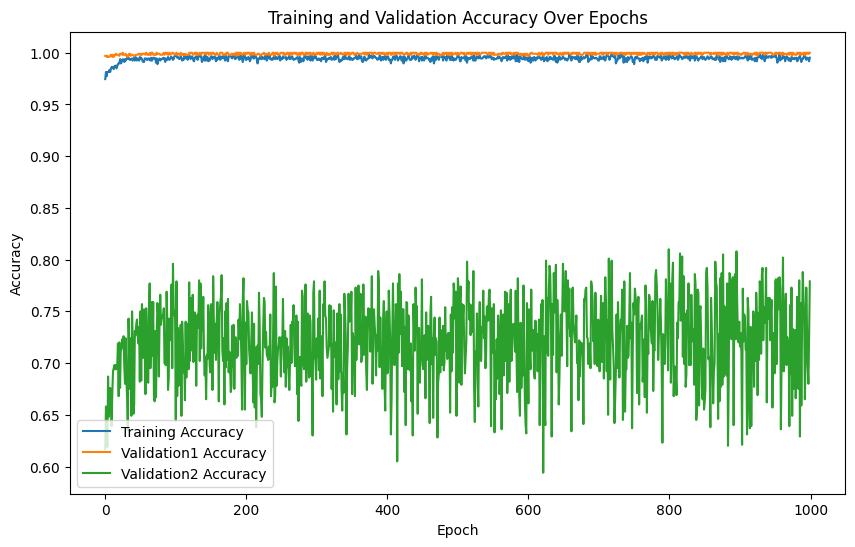

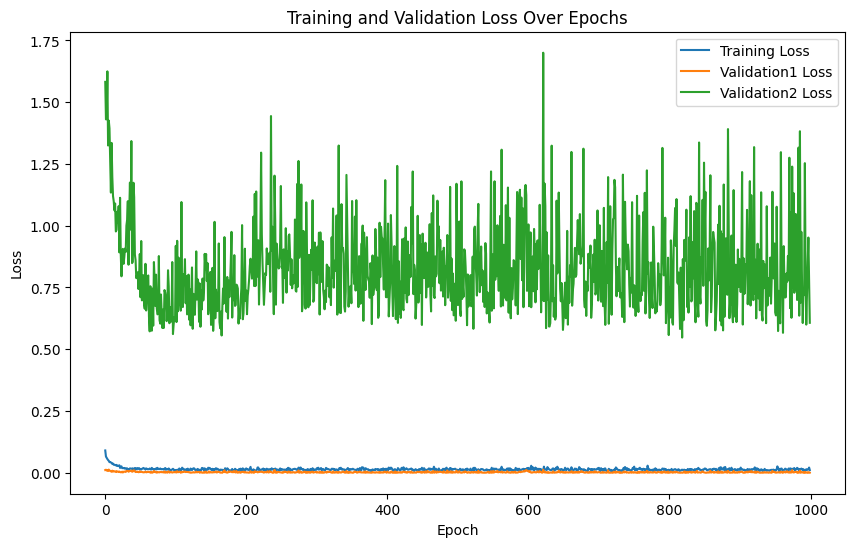

Accuracy: 0.9986206889152527


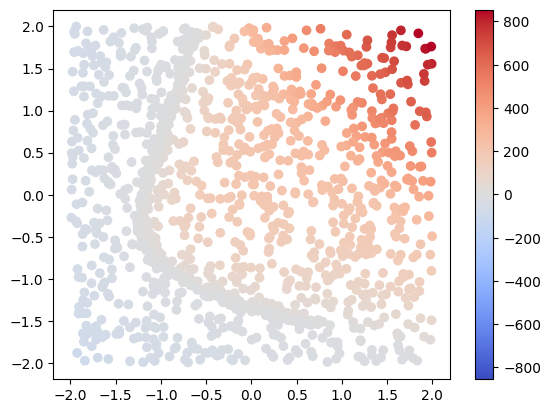

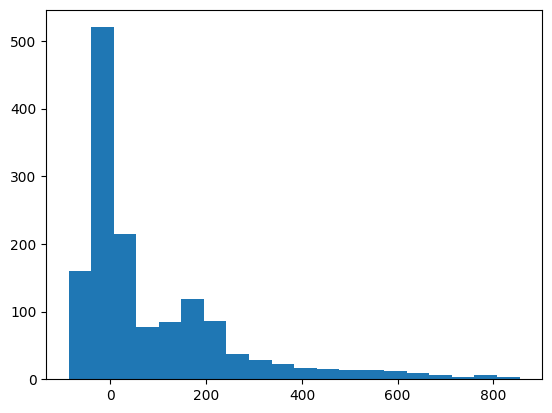

Accuracy: 1.0


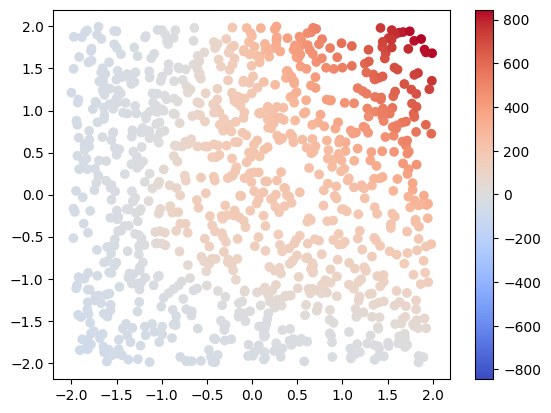

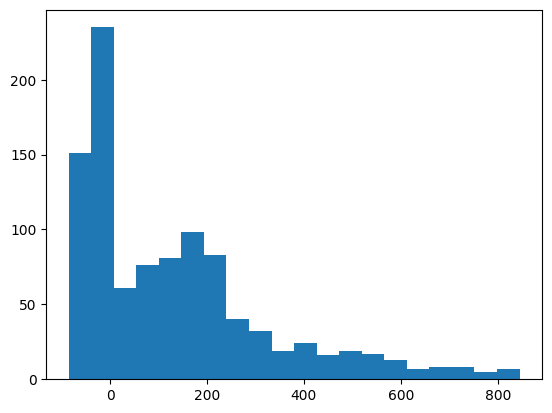

Accuracy: 0.7789999842643738


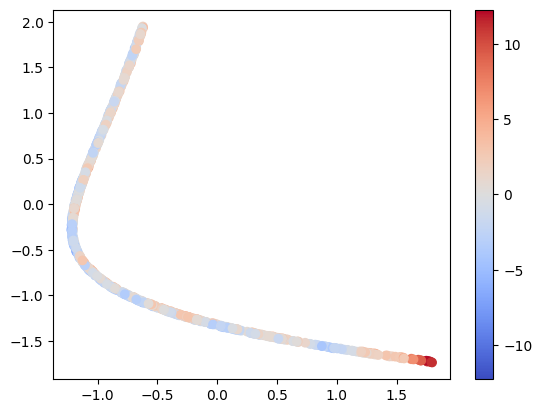

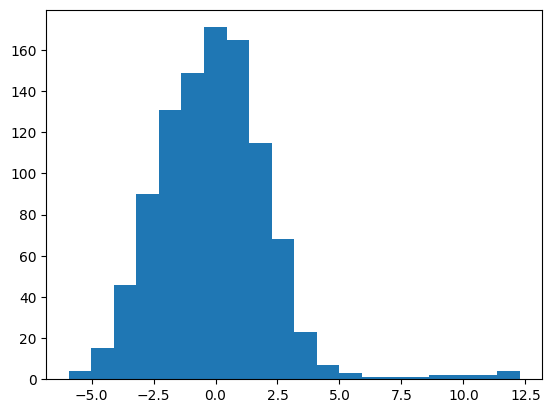

In [25]:
net_hinge = deepcopy(net_1)
train_model_hinge(net_hinge, dataset_train, dataset_validation_uniform, dataset_validation_near, batchsize=64, epochs=1000, lr=0.0001)


Accuracy: 1.0


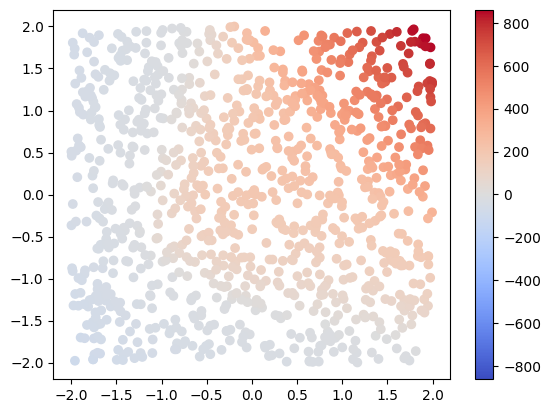

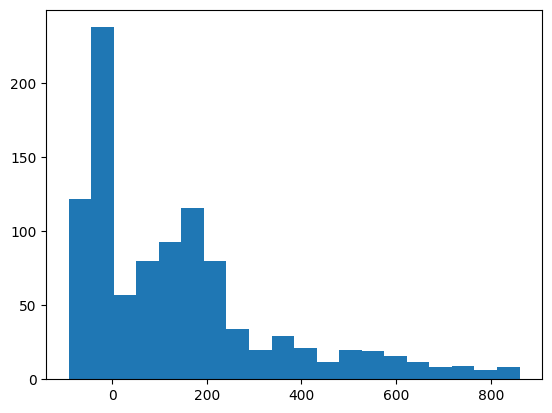

tensor(1.)

In [26]:
test_model(net_hinge, dataset_test_uniform)

Accuracy: 0.777999997138977


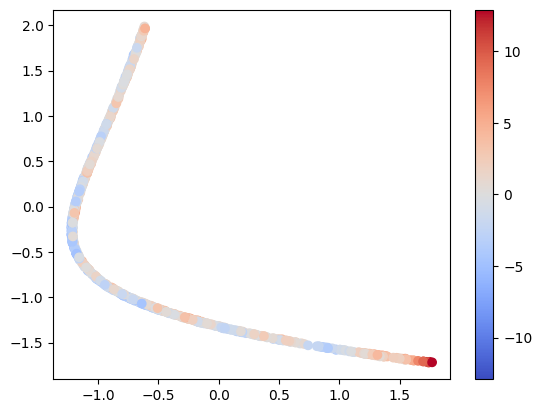

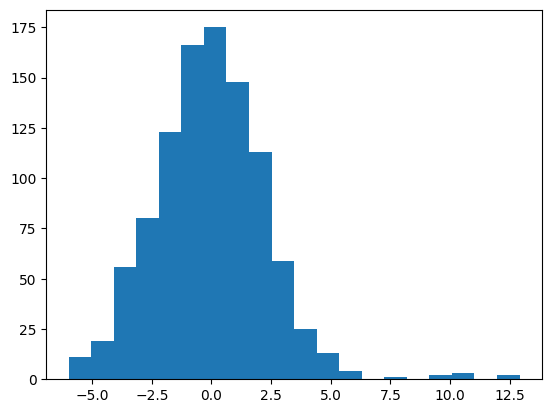

tensor(0.7780)

In [27]:
test_model(net_hinge, dataset_test_near)

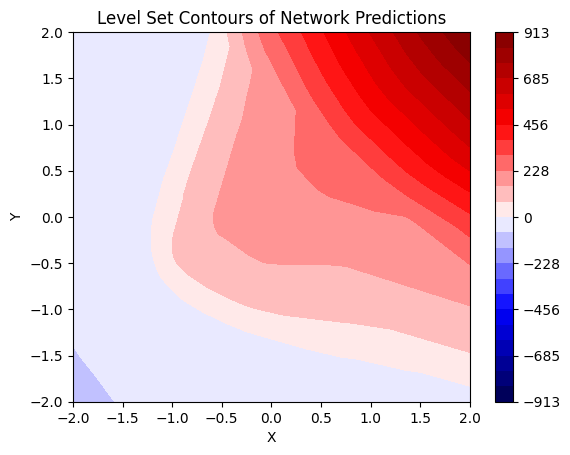

In [28]:
plot_contour(net_hinge)

In [29]:
def train_model_hinge_square(net, dataset_train, dataset_validation1, dataset_validation2, batchsize, epochs, lr):
    criterion = QuadraticHingeLoss()
    #optimizer = optim.Adam(net.parameters(), lr=lr)
    optimizer = Lion(net.parameters(), lr=lr, weight_decay=0.01)
    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
    dataloader_validation1 = DataLoader(dataset_validation1, batch_size=batchsize, shuffle=False)
    dataloader_validation2 = DataLoader(dataset_validation2, batch_size=batchsize, shuffle=False)
    
    training_accuracy_over_epochs = []
    validation1_accuracy_over_epochs = []
    validation2_accuracy_over_epochs = []
    training_loss_over_epochs = []
    validation1_loss_over_epochs = []
    validation2_loss_over_epochs = []
    
    # Set up the overall progress bar
    overall_progress = tqdm(total=epochs, desc='Overall Training Progress')
    
    for epoch in range(epochs):
        net.train()
        correct_train = 0
        total_train = 0
        avg_loss_train = 0
        for features, labels in dataloader_train:
            #labels = ((labels + 1) / 2).float()
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = net(features).view(-1)
            predicted = ((outputs > 0).float() * 2) - 1
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            loss = criterion(outputs, labels)
            avg_loss_train += loss.item()
            loss.backward()
            optimizer.step()
                    
        training_accuracy = correct_train / total_train
        training_loss = avg_loss_train / len(dataloader_train)
        training_accuracy_over_epochs.append(training_accuracy)
        training_loss_over_epochs.append(training_loss)

        
        net.eval()
        correct_validation1 = 0
        total_validation1 = 0
        avg_loss_validation1 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation1:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation1 += (predicted == labels).sum().item()
                total_validation1 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation1 += loss.item()
        
        validation1_accuracy = correct_validation1 / total_validation1
        validation1_accuracy_over_epochs.append(validation1_accuracy)
        validation1_loss = avg_loss_validation1 / len(dataloader_validation1)
        validation1_loss_over_epochs.append(validation1_loss)

        correct_validation2 = 0
        total_validation2 = 0
        avg_loss_validation2 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation2:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation2 += (predicted == labels).sum().item()
                total_validation2 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation2 += loss.item()
        
        validation2_accuracy = correct_validation2 / total_validation2
        validation2_accuracy_over_epochs.append(validation2_accuracy)
        validation2_loss = avg_loss_validation2 / len(dataloader_validation2)
        validation2_loss_over_epochs.append(validation2_loss)
        
        # Update the overall progress bar after each epoch
        overall_progress.update(1)
        overall_progress.set_postfix({'Training Accuracy': training_accuracy, 'Validation1 Accuracy': validation1_accuracy, 'Validation2 Accuracy': validation2_accuracy})
    
    overall_progress.close()
    
    # Plot training and validation accuracy over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(training_accuracy_over_epochs, label='Training Accuracy')
    plt.plot(validation1_accuracy_over_epochs, label='Validation1 Accuracy')
    plt.plot(validation2_accuracy_over_epochs, label='Validation2 Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()
    plt.show()

    # Plot training and validation loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(training_loss_over_epochs, label='Training Loss')
    plt.plot(validation1_loss_over_epochs, label='Validation1 Loss')
    plt.plot(validation2_loss_over_epochs, label='Validation2 Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()
    
    test_model(net, dataset_train)
    test_model(net, dataset_validation1)
    test_model(net, dataset_validation2)

Overall Training Progress: 100%|██████████| 1000/1000 [02:28<00:00,  6.74it/s, Training Accuracy=0.996, Validation1 Accuracy=1, Validation2 Accuracy=0.72]    


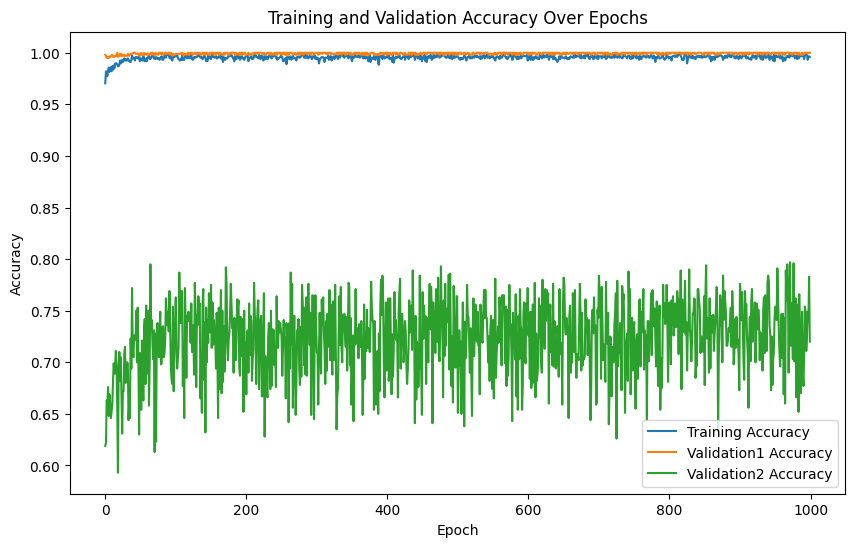

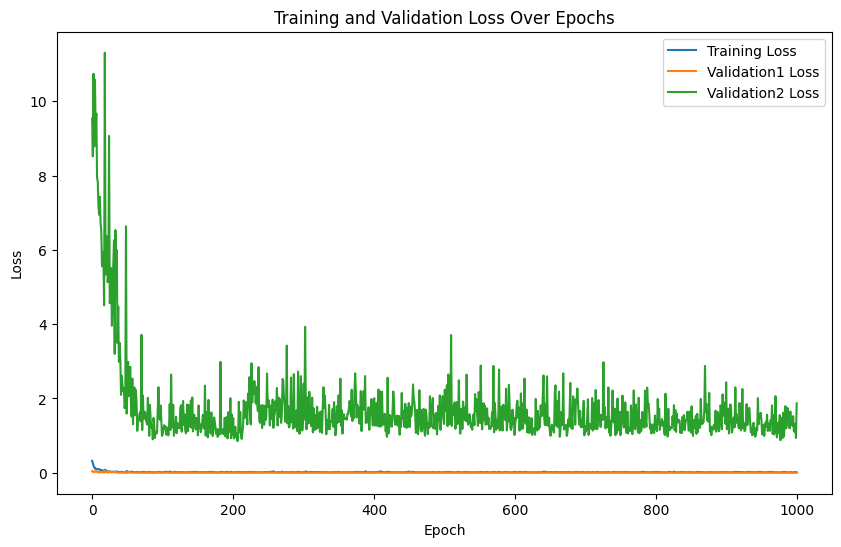

Accuracy: 0.9931034445762634


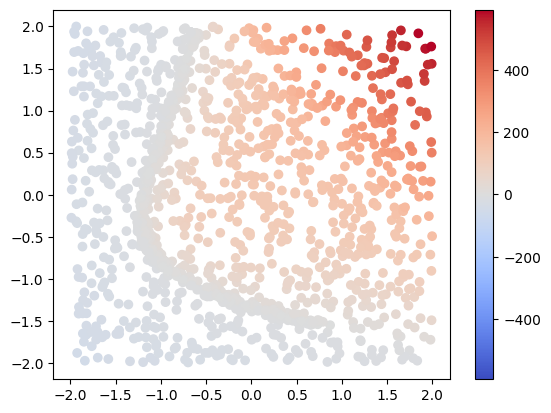

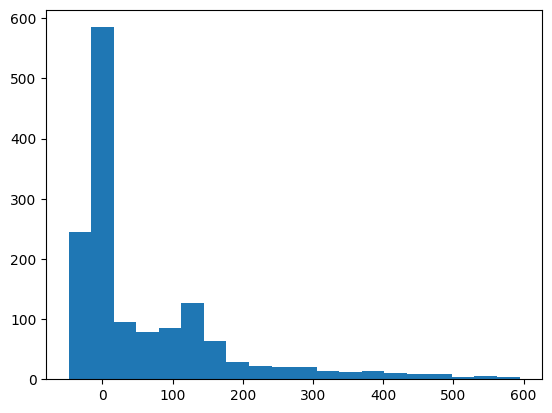

Accuracy: 1.0


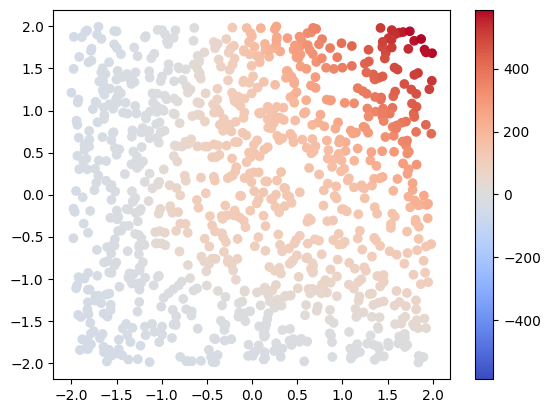

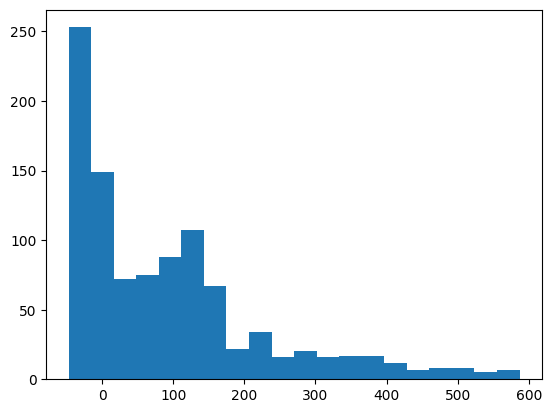

Accuracy: 0.7200000286102295


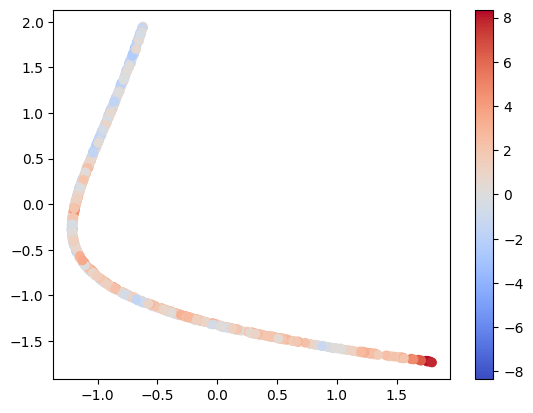

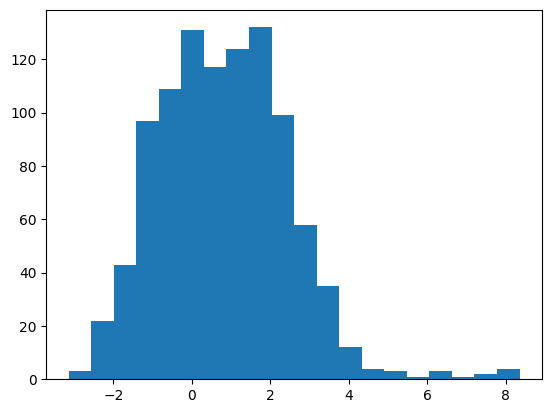

In [30]:
net_hinge_square = deepcopy(net_1)
train_model_hinge_square(net_hinge_square, dataset_train, dataset_validation_uniform, dataset_validation_near, batchsize=64, epochs=1000, lr=0.0001)

Accuracy: 1.0


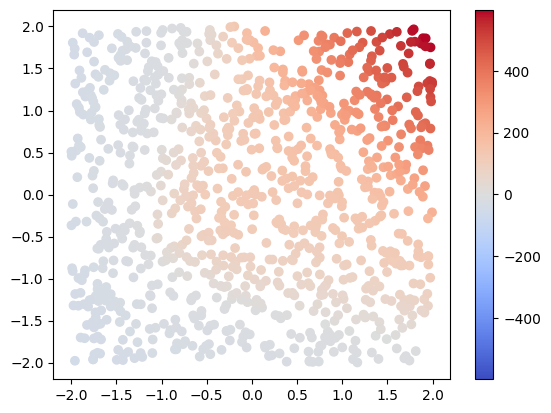

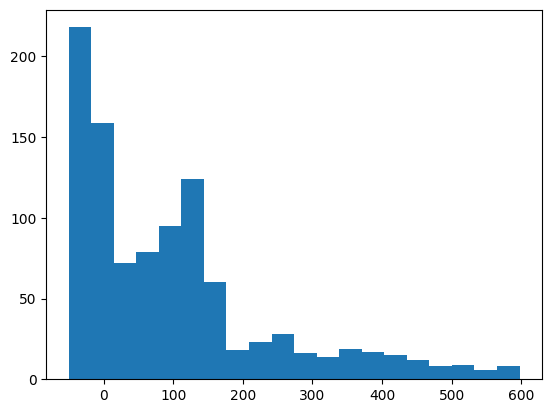

tensor(1.)

In [31]:
test_model(net_hinge_square, dataset_test_uniform)

Accuracy: 0.7020000219345093


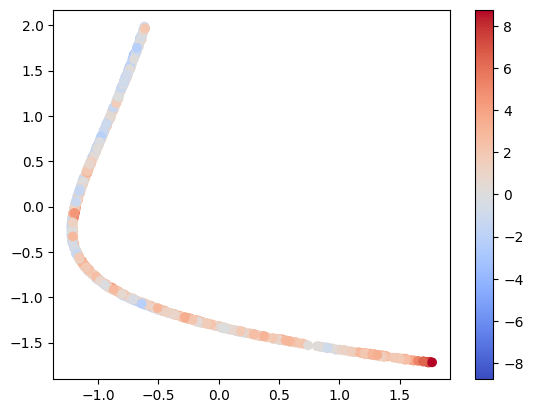

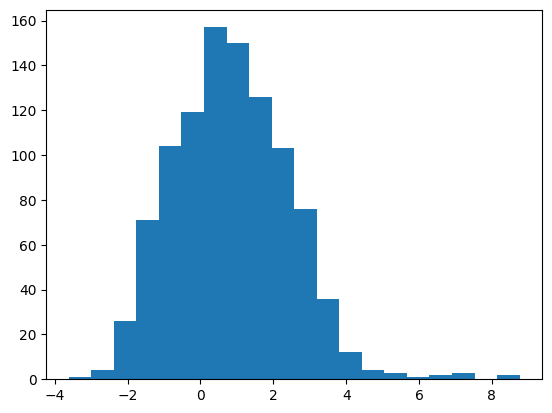

tensor(0.7020)

In [32]:
test_model(net_hinge_square, dataset_test_near)

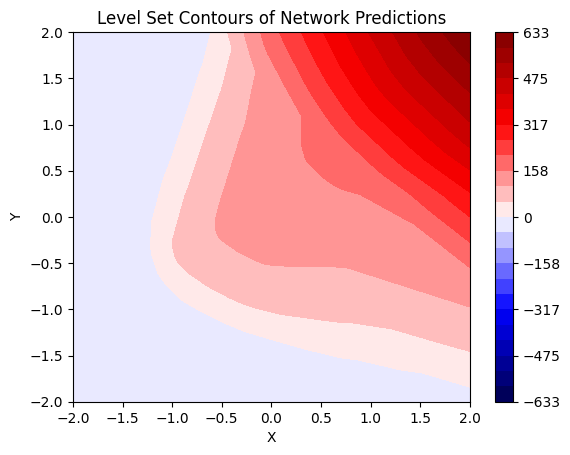

In [33]:
plot_contour(net_hinge_square)

## Dynamical loss

In [ ]:
# Assuming `f` is your trained neural network
# Example input point, requires_grad=True is crucial for gradient computation
f = net_3_1
input_point = torch.tensor([[-1, 0.5]], dtype=torch.float32, requires_grad=True)

# Forward pass: compute the probability
probability = f(input_point)

# Check if the output is scalar (as required for backward)
if probability.nelement() == 1:
    # Backward pass: compute the gradient of the output with respect to the input
    probability.backward()

    # Extract the gradient vector
    gradient_vector = input_point.grad
    print("Gradient vector at the input point:", gradient_vector)

    # Normalize the gradient vector
    l2_norm = gradient_vector.norm(p=2)
    if l2_norm.item() > 0:
        normalized_gradient_vector = gradient_vector / l2_norm
        print("Normalized gradient vector:", normalized_gradient_vector)
    else:
        print("The gradient vector is zero and cannot be normalized.")
else:
    print("The output is not a scalar. Gradient computation requires scalar output.")

In [ ]:
import torch

# Placeholder for gradient vectors
gradient_vectors = []

for i in range(len(input_matrix)):
    # Zero the gradients to ensure correct gradient calculation
    if input_matrix.grad is not None:
        input_matrix.grad.zero_()
    
    # Forward pass for the i-th point
    probability = net_3_1(input_matrix[i].unsqueeze(0))
    
    # Compute the gradient for the i-th point
    probability.backward()

    # Extract and store the gradient vector for the i-th point
    gradient_vectors.append(input_matrix.grad[i].clone())

# Optionally, normalize each gradient vector
normalized_gradient_vectors = [g / g.norm(p=2) if g.norm(p=2) > 0 else g for g in gradient_vectors]

print("Gradient vectors for each point:", gradient_vectors)
print("Normalized gradient vectors for each point:", normalized_gradient_vectors)
df_grad = pd.DataFrame(normalized_gradient_vectors, columns=['x', 'y'])
print(df_grad)
df_grad.to_csv('normalized_gradient_vectors.csv', index=False)
df_grad_u = pd.DataFrame(gradient_vectors, columns=['x', 'y'])
df_grad_u.to_csv('gradient_vectors.csv', index=False)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'input_matrix' is your input matrix and 'gradient_vectors' contains the computed gradients
# Convert input_matrix and gradient_vectors to numpy arrays for easier manipulation
points = input_matrix.detach().numpy()  # Detach and convert to numpy for plotting
gradients = np.array([g.detach().numpy() for g in normalized_gradient_vectors])  # Convert gradients to numpy

# Extract x and y coordinates of points
x_coords, y_coords = points[:, 0], points[:, 1]

# Extract x and y components of gradients
grad_x, grad_y = gradients[:, 0], gradients[:, 1]

# Plotting
plt.figure(figsize=(8, 6))
plt.quiver(x_coords, y_coords, grad_x, grad_y, angles='xy', scale_units='xy', scale=1, color='r')
plt.scatter(x_coords, y_coords, color='b', label='Input Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Gradient Vectors for Input Points')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def integrand(inputs, net, system, magnitude1=1.0):
    gradient_vectors = []
    system_vectors = []
    probability_values = []
    for input_point in inputs:
        input_point = torch.tensor(input_point, dtype=torch.float32, requires_grad=True)
        probability = net(input_point.unsqueeze(0))
        probability.backward()
        probability_values.append(probability.detach().numpy())
        gradient_vector = input_point.grad
        gradient_vectors.append(gradient_vector.detach().numpy())
        system_vector = system(0, input_point.detach().numpy())
        system_vectors.append(system_vector)
    normalized_gradient_vectors = [g / np.linalg.norm(g) if np.linalg.norm(g) > 0 else g for g in gradient_vectors]
    normalized_system_vectors = [s / np.linalg.norm(s) if np.linalg.norm(s) > 0 else s for s in system_vectors]
    dot_products = [(np.dot(g, s) ** 2) for g, s in zip(normalized_gradient_vectors, normalized_system_vectors)]
    gradient_norm = [np.linalg.norm(g) for g in gradient_vectors]
    dot_products = np.array(dot_products)
    gradient_norm = np.array(gradient_norm)
    probability_values = np.array(probability_values)
    #probability_values = net_3_1(torch.tensor(inputs, dtype=torch.float32)).detach().numpy()
    result = dot_products * gradient_norm
    def dirac(probability, var = 0.0001):
        return np.exp(-(probability)**2 / (2 * var**2)) / np.sqrt(2 * np.pi * var**2)
    return magnitude1 * result * dirac(probability_values)

In [ ]:
def norm_penalty(inputs, net, system, magnitude2=1.0):
    gradient_vectors = []
    probability_values = []
    for input_point in inputs:
        input_point = torch.tensor(input_point, dtype=torch.float32, requires_grad=True)
        probability = net(input_point.unsqueeze(0))
        probability.backward()
        probability_values.append(probability.detach().numpy())
        gradient_vector = input_point.grad
        gradient_vectors.append(gradient_vector.detach().numpy())
    gradient_norm = np.array([np.linalg.norm(g) for g in gradient_vectors])
    result = (gradient_norm - 1) ** 2
    result = result * gradient_norm
    probability_values = np.array(probability_values)
    probability_values = net_3_1(torch.tensor(inputs, dtype=torch.float32)).detach().numpy()
    def dirac(probability, var = 0.0001):
        return np.exp(-(probability)**2 / (2 * var**2)) / np.sqrt(2 * np.pi * var**2)
    return magnitude2 * result * dirac(probability_values)

In [ ]:
#def overall(inputs, net, system, magnitude1=1.0, magnitude2=1.0):
    #a = integrand(inputs, net, system, magnitude1)
    #b = norm_penalty(inputs, net, magnitude2)
    #print(a)
    #print(b)
    #return a+b

In [ ]:
def integrate_function_over_region_batched(func, net, system, x_limits=(-2, 2), y_limits=(-2, 2), N=1000, batch_size=1000, magnitude=1):
    x_start, x_end = x_limits
    y_start, y_end = y_limits
    dx = (x_end - x_start) / N
    dy = (y_end - y_start) / N
    
    # Pre-compute linspace for efficiency
    x_space = np.linspace(x_start, x_end, N + 1)
    y_space = np.linspace(y_start, y_end, N + 1)
    
    total_points = (N + 1) ** 2
    num_batches = int(np.ceil(total_points / batch_size))
    
    integral = 0
    
    for batch in range(num_batches):
        start_idx = batch * batch_size
        end_idx = min(start_idx + batch_size, total_points)
        
        batch_indices = np.unravel_index(np.arange(start_idx, end_idx), (N + 1, N + 1))
        x_batch = x_space[batch_indices[1]]
        y_batch = y_space[batch_indices[0]]
        inputs = np.vstack([x_batch, y_batch]).T
        
        Z_batch = func(inputs, net, system, magnitude).reshape(-1)
        
        weights_batch = np.ones_like(Z_batch)
        
        if batch == 0:
            weights_batch[:N+1] *= 0.5
            weights_batch[::N+1] *= 0.5
        if batch == num_batches - 1:
            weights_batch[-(N+1):] *= 0.5
            weights_batch[N::N+1] *= 0.5
        
        integral += np.sum(Z_batch * weights_batch * dx * dy)
    
    return integral

# Integrate using the batch processing function
integral_value = integrate_function_over_region_batched(integrand, net_3_1, system)
print(f"Integral value: {integral_value}")

In [ ]:
penalty_value = integrate_function_over_region_batched(norm_penalty, net_3_1, system)
print(f"Penalty value: {penalty_value}")

In [ ]:
class DynamicalLoss(nn.Module):
    def __init__(self):
        super(DynamicalLoss, self).__init__()

    def forward(self, net, df_dynamical, x_pred, y_true):
        y_pred = net(x_pred)
        loss = nn.functional.relu(1 - y_true * y_pred)
        mean_loss = torch.mean(loss)
        gradient_vectors = []
        system_vectors = []
        
        # Iterate over DataFrame rows
        for _, row in df_dynamical.iterrows():
            input_point = torch.tensor(row.values, dtype=torch.float32, requires_grad=True)
            probability = net(input_point.unsqueeze(0))
            probability.backward()
            gradient_vector = input_point.grad
            gradient_vectors.append(gradient_vector.detach().numpy())
            system_vector = system(0, input_point.detach().numpy())
            system_vectors.append(system_vector)
        
        normalized_gradient_vectors = [g / np.linalg.norm(g) if np.linalg.norm(g) > 0 else g for g in gradient_vectors]
        normalized_system_vectors = [s / np.linalg.norm(s) if np.linalg.norm(s) > 0 else s for s in system_vectors]
        dot_products = [(np.dot(g, s) ** 2) for g, s in zip(normalized_gradient_vectors, normalized_system_vectors)]
        inner_product = np.mean(dot_products)
        
        return mean_loss + inner_product


In [ ]:
def train_model_dynamical(net, dataset_train, dataset_validation1, dataset_validation2, batchsize, epochs, lr):
    criterion = DynamicalLoss()
    #optimizer = optim.Adam(net.parameters(), lr=lr)
    optimizer = Lion(net.parameters(), lr=lr, weight_decay=0.01)
    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
    dataloader_validation1 = DataLoader(dataset_validation1, batch_size=batchsize, shuffle=False)
    dataloader_validation2 = DataLoader(dataset_validation2, batch_size=batchsize, shuffle=False)
    
    training_accuracy_over_epochs = []
    validation1_accuracy_over_epochs = []
    validation2_accuracy_over_epochs = []
    training_loss_over_epochs = []
    validation1_loss_over_epochs = []
    validation2_loss_over_epochs = []
    
    # Set up the overall progress bar
    overall_progress = tqdm(total=epochs, desc='Overall Training Progress')
    
    for epoch in range(epochs):
        net.train()
        correct_train = 0
        total_train = 0
        avg_loss_train = 0
        for features, labels in dataloader_train:
            #labels = ((labels + 1) / 2).float()
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = net(features).view(-1)
            predicted = ((outputs > 0).float() * 2) - 1
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            loss = criterion(net, df_dynamical, features, labels)
            avg_loss_train += loss.item()
            loss.backward()
            optimizer.step()
                    
        training_accuracy = correct_train / total_train
        training_loss = avg_loss_train / len(dataloader_train)
        training_accuracy_over_epochs.append(training_accuracy)
        training_loss_over_epochs.append(training_loss)

        
        net.eval()
        correct_validation1 = 0
        total_validation1 = 0
        avg_loss_validation1 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation1:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation1 += (predicted == labels).sum().item()
                total_validation1 += labels.size(0)
                loss = criterion(net, df_dynamical, features, labels)
                avg_loss_validation1 += loss.item()
        
        validation1_accuracy = correct_validation1 / total_validation1
        validation1_accuracy_over_epochs.append(validation1_accuracy)
        validation1_loss = avg_loss_validation1 / len(dataloader_validation1)
        validation1_loss_over_epochs.append(validation1_loss)

        correct_validation2 = 0
        total_validation2 = 0
        avg_loss_validation2 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation2:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation2 += (predicted == labels).sum().item()
                total_validation2 += labels.size(0)
                loss = criterion(net, df_dynamical, features, labels)
                avg_loss_validation2 += loss.item()
        
        validation2_accuracy = correct_validation2 / total_validation2
        validation2_accuracy_over_epochs.append(validation2_accuracy)
        validation2_loss = avg_loss_validation2 / len(dataloader_validation2)
        validation2_loss_over_epochs.append(validation2_loss)
        
        # Update the overall progress bar after each epoch
        overall_progress.update(1)
        overall_progress.set_postfix({'Training Accuracy': training_accuracy, 'Validation1 Accuracy': validation1_accuracy, 'Validation2 Accuracy': validation2_accuracy})
    
    overall_progress.close()
    
    # Plot training and validation accuracy over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(training_accuracy_over_epochs, label='Training Accuracy')
    plt.plot(validation1_accuracy_over_epochs, label='Validation1 Accuracy')
    plt.plot(validation2_accuracy_over_epochs, label='Validation2 Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()
    plt.show()

    # Plot training and validation loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(training_loss_over_epochs, label='Training Loss')
    plt.plot(validation1_loss_over_epochs, label='Validation1 Loss')
    plt.plot(validation2_loss_over_epochs, label='Validation2 Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()
    
    test_model(net, dataset_train)
    test_model(net, dataset_validation1)
    test_model(net, dataset_validation2)

In [ ]:
net_4 = deepcopy(net_1)
#for param in net_4.fc1.parameters():
    #param.requires_grad = False
#for param in net_4.fc2.parameters():
    #param.requires_grad = False
#for param in net_4.fc3.parameters():
    #param.requires_grad = False
train_model_dynamical(net_4, dataset_train, dataset_validation_uniform, dataset_validation_near, batchsize=128, epochs=1000, lr=0.0001)

In [ ]:
test_model(net_4, dataset_test_uniform)

In [ ]:
test_model(net_4, dataset_test_near)

In [ ]:
plot_contour(net_4)

In [ ]:
integrate_function_over_region_batched(integrand, net_4, system)

In [ ]:
integrate_function_over_region_batched(norm_penalty, net_4, system)

## Benchmark: Sampling points at decision boundary

In [ ]:
from torch.autograd import Variable

def find_decision_boundary_batch(f, initial_points, lr=0.001, threshold=1e-6, max_iter=1000):
    f.eval()
    x = Variable(initial_points.clone(), requires_grad=True)
    optimizer = torch.optim.Adam([x], lr=lr)
    converged = torch.zeros(initial_points.size(0), dtype=torch.bool)
    
    for i in range(max_iter):
        optimizer.zero_grad()
        output = f(x)
        loss = (output) ** 2
        loss = loss.mean(dim=1)  # Assuming f returns a tensor of shape (n_points,)
        loss.backward(torch.ones_like(loss))
        optimizer.step()
        
        # Check convergence for each point
        converged |= (loss < threshold)
        if converged.all():
            print(f"All converged after {i+1} iterations.")
            break
    
    return x, converged


def collect_converged_points(f, target_count=1000):
    collected_points = []
    while len(collected_points) < target_count:
        n_points_needed = 10000
        initial_points = (torch.rand(n_points_needed, 2) * 4) - 2  # Generate more points
        x_star_batch, converged = find_decision_boundary_batch(f, initial_points)
        converged_points = x_star_batch[converged]
        
        # Generate random shifts
        shifts = (torch.rand(converged_points.size()) * 0.02) - 0.01  # Shifts in the range [-0.01, 0.01]
        converged_points_shifted = converged_points + shifts
        
        collected_points.extend(converged_points_shifted.detach().numpy().tolist())  # Convert to list and append
        
    return torch.tensor(collected_points[:target_count])  # Return the first 1,000 converged points

# Example usage
collected_points = collect_converged_points(net_3_1)
print(f"Collected {len(collected_points)} converged points.")
outputs = net_3_1(collected_points)
# Assuming collected_points and outputs are already defined as shown above
for point, output in zip(collected_points, outputs):
    print(f"Point: {point}, Output: {output.item()}")

def collect_converged_points_without_noise(f, target_count=5000):
    collected_points = []
    while len(collected_points) < target_count:
        n_points_needed = 10000
        initial_points = (torch.rand(n_points_needed, 2) * 4) - 2  # Generate more points
        x_star_batch, converged = find_decision_boundary_batch(f, initial_points)
        converged_points = x_star_batch[converged]
        collected_points.extend(converged_points.detach().numpy().tolist())  # Convert to list and append
        
    return torch.tensor(collected_points[:target_count])  # Return the first 1,000 converged points



In [ ]:
# Assuming collected_points is a tensor of shape (n_points, 2) where n_points >= 1000
x_coords = collected_points[:, 0].numpy()  # Extract x-coordinates
y_coords = collected_points[:, 1].numpy()  # Extract y-coordinates

plt.figure(figsize=(8, 8))  # Set the figure size for better visibility
plt.scatter(x_coords, y_coords, color='blue', label='Converged Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Visualization of Sampled Points')
plt.grid(True)
plt.show()

In [ ]:
def random_walk_on_boundary(classifier, start_point, system, )

In [ ]:
collected_points = collect_converged_points_without_noise(net_4)

# Convert to a PyTorch tensor if needed
input_matrix = torch.tensor(collected_points, dtype=torch.float32, requires_grad=True)

print(input_matrix)

In [ ]:
# Assuming collected_points is a tensor of shape (n_points, 2) where n_points >= 1000
x_coords = collected_points[:, 0].numpy()  # Extract x-coordinates
y_coords = collected_points[:, 1].numpy()  # Extract y-coordinates

plt.figure(figsize=(8, 8))  # Set the figure size for better visibility
plt.scatter(x_coords, y_coords, color='blue', label='Converged Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Visualization of Sampled Points')
plt.grid(True)
plt.show()

In [ ]:
b = system(0, (x_coords, y_coords))
b = np.array(b).T
b = b / torch.norm(torch.tensor(b), dim=1, keepdim=True)

In [ ]:
# Placeholder for gradient vectors
gradient_vectors = []

for i in range(len(input_matrix)):
    # Zero the gradients to ensure correct gradient calculation
    if input_matrix.grad is not None:
        input_matrix.grad.zero_()
    
    # Forward pass for the i-th point
    probability = net_1(input_matrix[i].unsqueeze(0))
    
    # Compute the gradient for the i-th point
    probability.backward()

    # Extract and store the gradient vector for the i-th point
    gradient_vectors.append(input_matrix.grad[i].clone())

# Optionally, normalize each gradient vector
normalized_gradient_vectors = [g / g.norm(p=2) if g.norm(p=2) > 0 else g for g in gradient_vectors]

print("Gradient vectors for each point:", gradient_vectors)
print("Normalized gradient vectors for each point:", normalized_gradient_vectors)
df_grad = pd.DataFrame(normalized_gradient_vectors, columns=['x', 'y'])
print(df_grad)
df_grad.to_csv('normalized_gradient_vectors.csv', index=False)
df_grad_u = pd.DataFrame(gradient_vectors, columns=['x', 'y'])
df_grad_u.to_csv('gradient_vectors.csv', index=False)

In [ ]:
# Assuming 'input_matrix' is your input matrix and 'gradient_vectors' contains the computed gradients
# Convert input_matrix and gradient_vectors to numpy arrays for easier manipulation
points = input_matrix.detach().numpy()  # Detach and convert to numpy for plotting
gradients = np.array([g.detach().numpy() for g in normalized_gradient_vectors])  # Convert gradients to numpy

# Extract x and y coordinates of points
x_coords, y_coords = points[:, 0], points[:, 1]

# Extract x and y components of gradients
grad_x, grad_y = gradients[:, 0], gradients[:, 1]

# Plotting
plt.figure(figsize=(8, 6))
plt.quiver(x_coords, y_coords, grad_x, grad_y, angles='xy', scale_units='xy', scale=1, color='r')
plt.scatter(x_coords, y_coords, color='b', label='Input Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Gradient Vectors for Input Points')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
inner_product = np.sum(np.array(normalized_gradient_vectors) * b.numpy(), axis=1)
print(inner_product)

In [ ]:
weights = np.ones_like(inner_product) / len(inner_product)
plt.hist(inner_product, bins=50, range=(-1, 1), weights=weights)
print(inner_product.mean())
print(inner_product.std())


In [ ]:
def evaluate_sample_accuracy(net):
    net.eval()
    collected_points = collect_converged_points(net)
    if collected_points.ndim == 2 and collected_points.shape[1] >= 2:
        x0 = collected_points[:, 0].flatten()
        y0 = collected_points[:, 1].flatten()
        outputs = net(collected_points) > 0
        labels = [simulation(x0[i], y0[i]) for i in range(len(x0))] 
        correct = sum(output == label for output, label in zip(outputs, labels))  
        accuracy = correct / len(outputs)
        print(f"Sample accuracy: {accuracy}")
        return accuracy
    else:
        print("Error: collected_points does not have the expected shape.")
        return 0
    
evaluate_sample_accuracy(net_3_1)

In [ ]:
avg_3 = 0
for i in range(5):
    avg_3 += evaluate_sample_accuracy(net_3_1)
avg_3 /= 5
print(avg_3)

In [ ]:
avg_1 = 0
for i in range(5):
    avg_1 += evaluate_sample_accuracy(net_1)
avg_1 /= 5
print(avg_1)

In [ ]:
avg_2 = 0
for i in range(5):
    avg_2 += evaluate_sample_accuracy(net_2)
avg_2 /= 5
print(avg_2)

In [ ]:
avg_4 = 0
for i in range(5):
    avg_4 += evaluate_sample_accuracy(net_4)
avg_4 /= 5
print(avg_4)